<a href="https://colab.research.google.com/github/ChiragHooda/Anirbnb_Newyork_Analysis/blob/main/Airbnb_NewYork_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install opendatasets

In [7]:
import opendatasets as od

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from scipy.stats import entropy
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error


# **LOADING DATA & BASIC DISTRIBUTION**

In [9]:
columns_to_keep = [
    'reviews_per_month',
    'calculated_host_listings_count_shared_rooms',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count',
    'instant_bookable',
    'review_scores_value',
    'review_scores_location',
    'review_scores_communication',
    'review_scores_checkin',
    'review_scores_cleanliness',
    'review_scores_accuracy',
    'review_scores_rating',
    'last_review',
    'first_review',
    'estimated_revenue_l365d',
    'estimated_occupancy_l365d',
    'number_of_reviews_ly',
    'availability_eoy',
    'number_of_reviews_l30d',
    'number_of_reviews_ltm',
    'number_of_reviews',
    'calendar_last_scraped',
    'availability_365',
    'availability_90',
    'availability_60',
    'availability_30',
    'has_availability',
    'maximum_nights_avg_ntm',
    'minimum_nights_avg_ntm',
    'maximum_maximum_nights',
    'minimum_maximum_nights',
    'maximum_minimum_nights',
    'minimum_minimum_nights',
    'maximum_nights',
    'minimum_nights',
    'price',
    'beds',
    'bedrooms',
    'host_about',
    'neighborhood_overview',
    'description',
    'host_is_superhost',
    'room_type',
    'accommodates',
    'name',
    'amenities',
    'latitude',
    'longitude',
    'neighbourhood',
    'host_name',
    'host_id',
    'id'
]

listings = pd.read_csv(
    "/content/listings_NewYork.csv",
    usecols=columns_to_keep,
    on_bad_lines='skip',   # skips corrupted rows
    engine="python"        # more tolerant parser
)


In [10]:
listings.shape

(15398, 53)

In [11]:
listings.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [12]:
categorical_columns = listings.select_dtypes(include="object").columns
numerical_columns = listings.select_dtypes(include = ['int64', 'float64']).columns

In [13]:
total_nan = listings.isna().sum().sort_values(ascending = False)
percentage_nan = (total_nan / listings.shape[0]) * 100
missing_data = pd.concat([total_nan, percentage_nan], axis = 1, keys = ["Total_Nan", "%_Nan"])
missing_data

Total_Nan      %_Nan
price                                              9977  64.794129
estimated_revenue_l365d                            9977  64.794129
beds                                               9926  64.462917
host_about                                         5962  38.719314
neighborhood_overview                              5506  35.757891
neighbourhood                                      5505  35.751396
has_availability                                   4727  30.698792
bedrooms                                           4196  27.250292
review_scores_location                             3051  19.814262
review_scores_value                                3051  19.814262
review_scores_checkin                              3049  19.801273
review_scores_accuracy                             3045  19.775295
review_scores_communication                        3041  19.749318
review_scores_cleanliness                          3036  19.716846
first_review                                       3035  19.710352
reviews_per_month                                  3035  19.710352
review_scores_rating                               3035  19.710352
last_review                                        3035  19.710352
description                                         583   3.786206
host_is_superhost                                   108   0.701390
host_name                                             8   0.051955
name                                                  2   0.012989
estimated_occupancy_l365d                             1   0.006494
maximum_minimum_nights                                1   0.006494
number_of_reviews_ly                                  1   0.006494
amenities                                             1   0.006494
longitude                                             1   0.006494
maximum_nights                                        1   0.006494
minimum_nights                                        1   0.006494
latitude                                              1   0.006494
accommodates                                          1   0.006494
room_type                                             1   0.006494
minimum_minimum_nights                                1   0.006494
maximum_nights_avg_ntm                                1   0.006494
minimum_maximum_nights                                1   0.006494
minimum_nights_avg_ntm                                1   0.006494
maximum_maximum_nights                                1   0.006494
availability_90                                       1   0.006494
availability_60                                       1   0.006494
availability_eoy                                      1   0.006494
number_of_reviews_l30d                                1   0.006494
number_of_reviews_ltm                                 1   0.006494
number_of_reviews                                     1   0.006494
calendar_last_scraped                                 1   0.006494
availability_365                                      1   0.006494
calculated_host_listings_count                        1   0.006494
calculated_host_listings_count_entire_homes           1   0.006494
availability_30                                       1   0.006494
instant_bookable                                      1   0.006494
calculated_host_listings_count_private_rooms          1   0.006494
calculated_host_listings_count_shared_rooms           1   0.006494
id                                                    0   0.000000
host_id                                               0   0.000000

In [14]:
listings.head(10)

id                                               name  \
0   2539   Superfast Wi-Fi.  Clean & quiet home by the park   
1   2595           Skylit Midtown Manhattan Spacious Studio   
2   5136    Spacious Family Friendly Duplex w/ Patio + Yard   
3   6848                   Only 2 stops to Manhattan studio   
4   6872  Uptown Sanctuary w/ Private Bath (Month to Month)   
5   6990                            UES Beautiful Blue Room   
6   7064  Amazing location! Wburg. Large, bright & tranquil   
7   7097      Perfect for Your Parents, With Garden & Patio   
8  59121                          Convenient 3BR w/6 beds!!   
9  60181          Sunny East Village Apartment with rooftop   

                                         description  \
0  Bright, serene room in a renovated apartment h...   
1  Beautiful, spacious skylit studio in the heart...   
2  We welcome you to stay in our lovely 2 br, 130...   
3  Comfortable studio apartment with super comfor...   
4  This charming distancing-friendly month-to-mon...   
5                    Beautiful peaceful healthy home   
6  Large, private loft-like room in a spacious 2-...   
7  Parents/grandparents coming to town or are you...   
8  Convenient location for this apartment.<br />E...   
9  Our sunny apt has an open floor plan, with a m...   

                               neighborhood_overview  host_id  host_name  \
0    Close to Prospect Park and Historic Ditmas Park     2787       John   
1  Centrally located in the heart of Manhattan ju...     2845   Jennifer   
2                                                NaN     7378    Rebecca   
3                                                NaN    15991      Allen   
4  This sweet Harlem sanctuary is a 10-20 minute ...    16104  Kahshanna   
5  Location: Five minutes to Central Park, Museum...    16800    Cynthia   
6  - One stop from the East Village, Lower East S...    17297     Joelle   
7  Residential, village-like atmosphere. Lots of ...    17571       Jane   
8                                                NaN   204539       Mark   
9  The East Village is one of the most lively and...   128806        Sue   

                                          host_about host_is_superhost  \
0  Educated professional living in Brooklyn.  I l...                 f   
1  A New Yorker since 2000! My passion is creatin...                 f   
2  Rebecca is an artist/designer, and Henoch is i...                 f   
3  We love to travel. When we travel we like to s...                 t   
4  A former life in fashion and wellness has left...                 f   
5  Capturing the Steinbeck side of life in its Fi...                 f   
6  I have lived in the same apartment in Brooklyn...                 f   
7  I appreciate visitors and know New York well, ...                 t   
8                       Father of two boys - 17 & 19                 f   
9  I am a journalist, photographer, and artist. M...                 f   

             neighbourhood  latitude  ...  review_scores_checkin  \
0  Neighborhood highlights  40.64529  ...                   5.00   
1  Neighborhood highlights  40.75356  ...                   4.77   
2                      NaN  40.66265  ...                   5.00   
3                      NaN  40.70935  ...                   4.85   
4  Neighborhood highlights  40.80107  ...                   5.00   
5  Neighborhood highlights  40.78778  ...                   4.96   
6  Neighborhood highlights  40.71248  ...                   5.00   
7  Neighborhood highlights  40.69194  ...                   4.97   
8                      NaN  40.70271  ...                   5.00   
9  Neighborhood highlights  40.72530  ...                   4.97   

  review_scores_communication  review_scores_location  review_scores_value  \
0                        5.00                    4.75                 4.88   
1                        4.80                    4.81                 4.40   
2                        5.00                    4.75       

In [15]:
numerical_columns

Index(['id', 'host_id', 'latitude', 'longitude', 'accommodates', 'bedrooms',
       'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_

In [16]:
categorical_columns

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_about', 'host_is_superhost', 'neighbourhood', 'room_type',
       'amenities', 'price', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'instant_bookable'],
      dtype='object')

# **EXPLORATORY DATA ANALYSIS**

## **UNIVARIATE ANALYSIS**

### **NUMERICAL COLUMNS**

In [17]:
def univariate_analysis(df, col, N = 10):
  print('============================================================= DESCRIPTION =============================================================')
  print(df[col].describe())
  print('\n')
  print('============================================================= MISSING DATA =============================================================')
  # print("Count of Null Valus = {count} and %age of null values = {percentage}".format(count = missing_data.loc[col, 'Total_Nan'], percentage = missing_data.loc[col, '%_Nan']))
  # print('\n')
  print('============================================================= HISTOGRAM =============================================================')
  sns.histplot(data = df, x = col)
  plt.show()
  print('============================================================= BOXPLOT =============================================================')
  sns.boxplot(data = df, x = col)
  plt.show()
  print('============================================================= SKEWNESS =============================================================')
  print(df[col].skew())
  print('\n')
  # N = int(input("How many top/bottom N values do you want?"))
  print('============================================================= TOP {N} VALUES =============================================================')
  print(df[col].value_counts().sort_values(ascending = False).head(N))
  print('============================================================= BOTTOM {N} VALUES =============================================================')
  print(df[col].value_counts().sort_values(ascending = False).tail(N))

In [18]:
numerical_columns

Index(['id', 'host_id', 'latitude', 'longitude', 'accommodates', 'bedrooms',
       'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_

In [19]:
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3781501493.py:1: SyntaxWarning: invalid escape sequence '\$'
  listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)


============================================================= DESCRIPTION =============================================================
count    5421.000000
mean      201.990777
std       253.044205
min        10.000000
25%        89.000000
50%       143.000000
75%       225.000000
max      7500.000000
Name: price, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


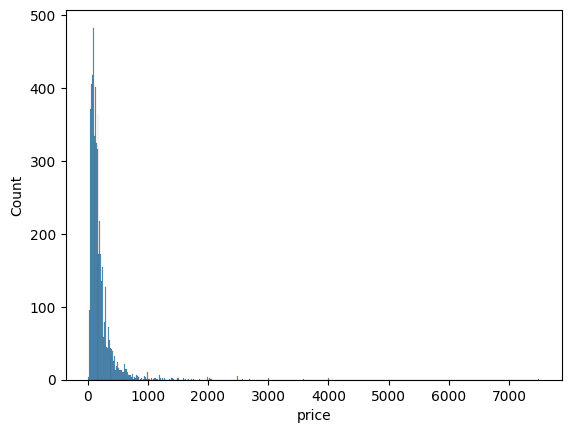

============================================================= BOXPLOT =============================================================


============================================================= SKEWNESS =============================================================
9.328725490046743


============================================================= TOP {N} VALUES =============================================================
price
150.0    106
200.0     83
90.0      82
100.0     80
125.0     71
80.0      64
170.0     64
95.0      63
135.0     62
120.0     61
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
price
487.0     1
612.0     1
401.0     1
505.0     1
754.0     1
553.0     1
1271.0    1
1129.0    1
2025.0    1
378.0     1
Name: count, dtype: int64


In [20]:
univariate_analysis(listings, 'price')

In [21]:
def analyze_geo(df, lat_col='latitude', lon_col='longitude'):
    """
    Perform univariate analysis on latitude and longitude columns.

    Parameters:
        df (pd.DataFrame): Your dataset
        lat_col (str): name of latitude column
        lon_col (str): name of longitude column
    """

    # 1. Descriptive stats
    print("\n--- Descriptive Statistics ---")
    print(df[[lat_col, lon_col]].describe())

    # 2. Histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(df[lat_col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {lat_col}")

    sns.histplot(df[lon_col], kde=True, ax=axes[1])
    axes[1].set_title(f"Distribution of {lon_col}")
    plt.show()

    # 3. Scatter plot (map view)
    plt.figure(figsize=(8, 6))
    plt.scatter(df[lon_col], df[lat_col], alpha=0.3, s=10)
    plt.xlabel(lon_col)
    plt.ylabel(lat_col)
    plt.title("Geographical Distribution of Listings")
    plt.show()

    # 4. KDE Heatmap
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=df[lon_col], y=df[lat_col], fill=True, cmap="Reds", thresh=0.05)
    plt.xlabel(lon_col)
    plt.ylabel(lat_col)
    plt.title("Density Heatmap of Locations")
    plt.show()

    # 5. Outlier ranges (optional check)
    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()
    print("\n--- Range Check ---")
    print(f"{lat_col} range: {lat_min:.4f} to {lat_max:.4f}")
    print(f"{lon_col} range: {lon_min:.4f} to {lon_max:.4f}")

    # crude rule for NYC-like data; can be adjusted for your dataset
    invalid_lat = df[(df[lat_col] < 40) | (df[lat_col] > 41)]
    invalid_lon = df[(df[lon_col] < -74.2) | (df[lon_col] > -73.7)]

    print(f"\nPotential outliers in {lat_col}: {len(invalid_lat)} rows")
    print(f"Potential outliers in {lon_col}: {len(invalid_lon)} rows")


--- Descriptive Statistics ---
           latitude     longitude
count  15397.000000  15397.000000
mean      40.729497    -73.951171
std        0.055736      0.047091
min       40.508630    -74.241350
25%       40.688930    -73.982130
50%       40.723770    -73.955470
75%       40.764100    -73.935750
max       40.911390    -73.713650


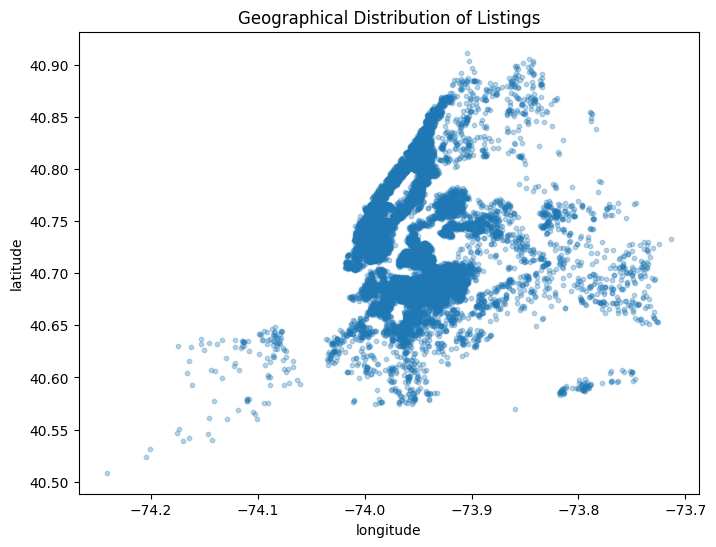

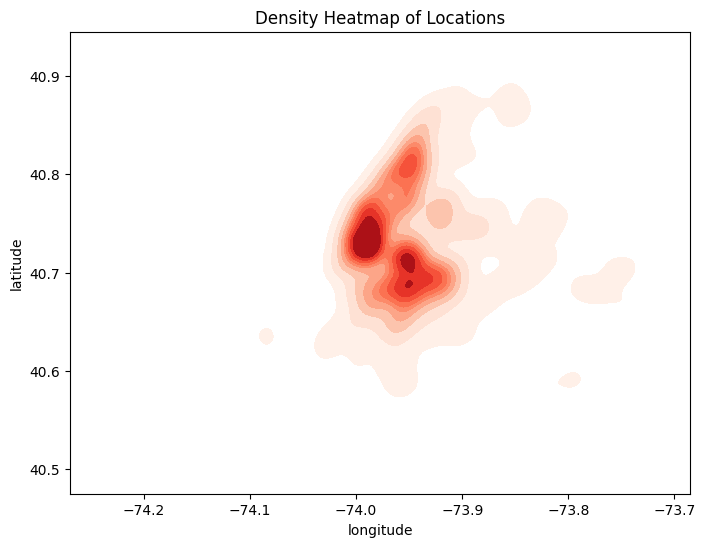


--- Range Check ---
latitude range: 40.5086 to 40.9114
longitude range: -74.2413 to -73.7137

Potential outliers in latitude: 0 rows
Potential outliers in longitude: 3 rows


In [22]:
analyze_geo(listings, 'latitude', 'longitude')

### **CATEGORICAL COLUMNS**

In [23]:
def univariate_categorical(df, col, top_n=5):
    """
    Perform univariate analysis for categorical columns.

    Parameters:
    df : pandas.DataFrame
        The dataframe containing the column.
    col : str
        Column name (categorical).
    top_n : int
        Number of top/bottom categories to display.
    """

    print(f"\n{'='*50}")
    print(f"Univariate Analysis of Categorical Column: {col}")
    print(f"{'='*50}\n")

    # Basic summary
    print("📌 Basic Summary:")
    print(f"- Missing values: {df[col].isna().sum()} ({df[col].isna().mean()*100:.2f}%)")
    print(f"- Unique categories: {df[col].nunique()}")
    if not df[col].mode().empty:
        print(f"- Mode (most frequent): {df[col].mode()[0]}")

    # Frequency distribution
    freq = df[col].value_counts()
    freq_perc = df[col].value_counts(normalize=True) * 100

    print("\n📊 Frequency Distribution (Top categories):")
    print(pd.DataFrame({"Count": freq.head(top_n), "Percent": freq_perc.head(top_n).round(2)}))

    if len(freq) > top_n:
        print("\n📉 Bottom categories:")
        print(pd.DataFrame({"Count": freq.tail(top_n), "Percent": freq_perc.tail(top_n).round(2)}))

    # Entropy (diversity of distribution)
    ent = entropy(freq_perc/100)
    norm_ent = ent / np.log2(len(freq_perc)) if len(freq_perc) > 1 else 0
    print(f"\n🔀 Entropy (distribution diversity): {ent:.4f} (Normalized: {norm_ent:.4f})")

    # Visualization - Count Plot
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col, order=freq.index)
    plt.xticks(rotation=45)
    plt.title(f"Count Plot of {col}")
    plt.show()

    # Pie chart (optional, if number of categories <= 10)
    if df[col].nunique() <= 10:
        plt.figure(figsize=(6,6))
        plt.pie(freq, labels=freq.index, autopct='%1.1f%%', startangle=90)
        plt.title(f"Pie Chart of {col}")
        plt.show()

In [24]:
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3781501493.py:1: SyntaxWarning: invalid escape sequence '\$'
  listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)


In [25]:
categorical_columns

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_about', 'host_is_superhost', 'neighbourhood', 'room_type',
       'amenities', 'price', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'instant_bookable'],
      dtype='object')


Univariate Analysis of Categorical Column: instant_bookable

📌 Basic Summary:
- Missing values: 1 (0.01%)
- Unique categories: 2
- Mode (most frequent): f

📊 Frequency Distribution (Top categories):
                  Count  Percent
instant_bookable                
f                 13717    89.09
t                  1680    10.91

🔀 Entropy (distribution diversity): 0.3447 (Normalized: 0.3447)


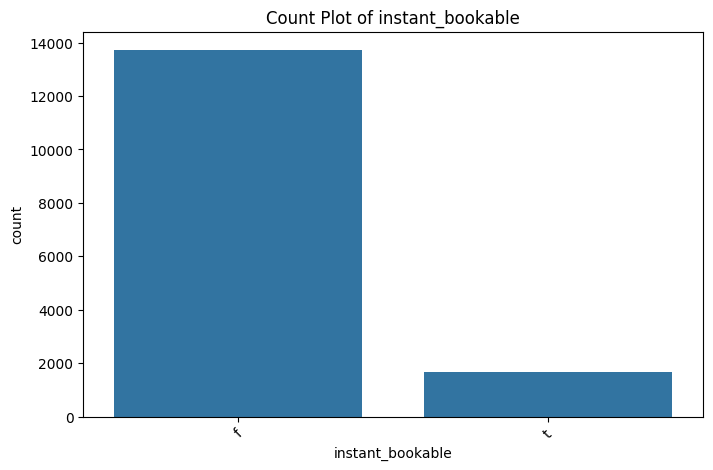

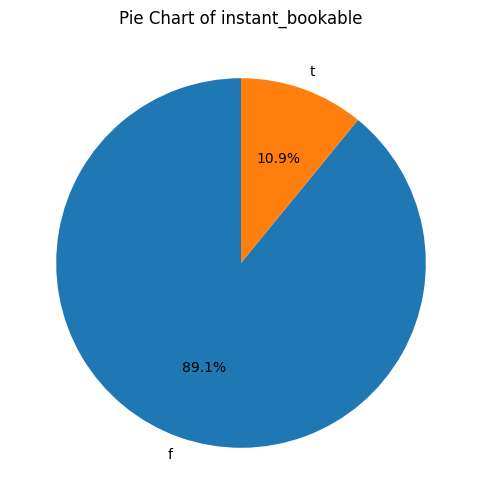

In [26]:
univariate_categorical(listings, 'instant_bookable', 10)

In [27]:
listings['instant_bookable'].value_counts()

instant_bookable
f    13717
t     1680
Name: count, dtype: int64

<Axes: xlabel='room_type', ylabel='price'>

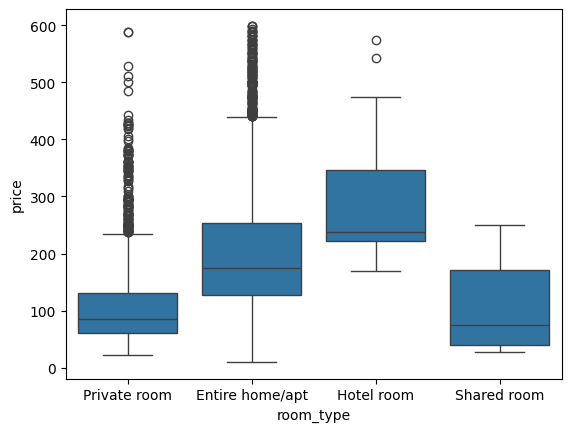

In [28]:
sns.boxplot(x = 'room_type', y = 'price', data = listings[listings.price < 600])

In [29]:
listings[(listings.room_type == 'Hotel room')].price.describe()

count     25.000000
mean     330.320000
std      174.218904
min      170.000000
25%      224.000000
50%      240.000000
75%      400.000000
max      900.000000
Name: price, dtype: float64

It looks like 'Hotel rooms' are the reason for so much inconsistency in our price column. I think we should remove 'Hotel room' listings because:
**very low count + inconsistent pricing scale + not part of Airbnb’s main P2P model**.

In [30]:
listings = listings[listings['room_type'] != 'Hotel room']

## **IMPUTING DATA & CAPPING**

### Capping and Transforming

Let's first deal with the colums with a lot of outliers:

**Extreme Skewness (>100)**:

estimated_revenue_l365d (skewness = 107.02, max = 12.75M)✅

maximum_nights (skewness = 190.55, max = 2.147B)✅

minimum_maximum_nights (skewness = 85.215, max = 2.147B)✅

maximum_maximum_nights (skewness = 40.18, max = 2.147B)✅

maximum_nights_avg_ntm (skewness = 40.18, max = 2.147B)✅

**Very High Skewness (15-40)**:

minimum_nights (skewness = 15.48, max = 1124)

minimum_minimum_nights (skewness = 15.58, max = 1124)

minimum_nights_avg_ntm (skewness = 14.196, max = 1124)

number_of_reviews_ltm (skewness = 36.29, max = 1786)

number_of_reviews_l30d (skewness = 40.18, max = 153)

number_of_reviews_ly (skewness = 37.76, max = 1797)

reviews_per_month (skewness = 19.99, max = 121.97)

calculated_host_listings_count_shared_rooms (skewness = 27.13, max = 17)

**Moderate High Skewness (2-5**):

beds (skewness = 4.18, max = 40)

calculated_host_listings_count_entire_homes (skewness = 4.19, max = 1054)

bedrooms (skewness = 2.18, max = 15)

accommodates (skewness = 2.67, max = 13)

Looks like the 2.147B max vlaue for each of the fields is due to some error as it's the maximum value of integer, so there must be curruption in the data. Better to remove this data take the 99th percentile and replace such data with that value.

##### But let's first see what would be it's impact on the columns without doing it inplace:

 'maximum_nights'. ✅

 'minimum_maximum_nights '. ✅

 'maximum_maximum_nights'. ✅

 'maximum_nights_avg_ntm'. ✅



In [31]:
reasonable_max = listings[listings['maximum_nights_avg_ntm'] < 1000000]['maximum_nights_avg_ntm'].quantile(0.99)
new_nights = listings['maximum_nights_avg_ntm'].clip(upper=reasonable_max)
new_nights

0         730.0
1        1125.0
2         730.0
3         120.0
4         180.0
          ...  
15393     730.0
15394    1125.0
15395    1125.0
15396    1125.0
15397       NaN
Name: maximum_nights_avg_ntm, Length: 15333, dtype: float64

In [32]:
new_df = pd.DataFrame(new_nights)

============================================================= DESCRIPTION =============================================================
count    15332.000000
mean       807.195102
std        465.206704
min          2.000000
25%        300.000000
50%       1125.000000
75%       1125.000000
max       1125.000000
Name: maximum_nights_avg_ntm, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


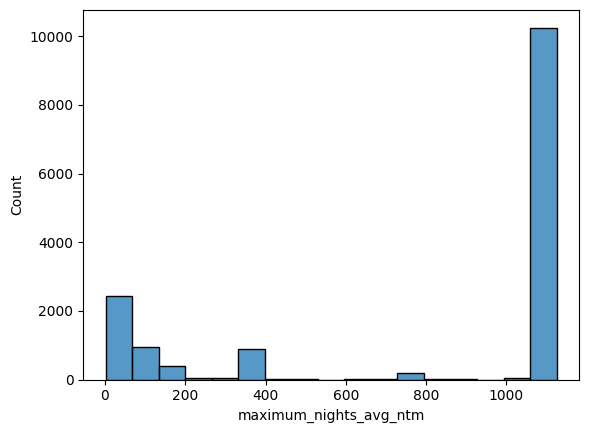

============================================================= BOXPLOT =============================================================


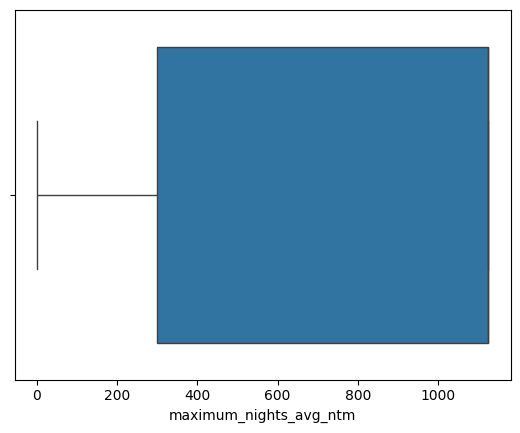

============================================================= SKEWNESS =============================================================
-0.8488286045594231


============================================================= TOP {N} VALUES =============================================================
maximum_nights_avg_ntm
1125.0    10136
30.0       1057
365.0       760
90.0        533
60.0        482
31.0        219
180.0       218
120.0       177
730.0       157
45.0        100
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
maximum_nights_avg_ntm
170.1     1
562.9     1
76.1      1
1001.0    1
223.9     1
636.0     1
801.3     1
802.3     1
1078.9    1
704.2     1
Name: count, dtype: int64


In [33]:
univariate_analysis(new_df, 'maximum_nights_avg_ntm')

##### Converting the columns

In [34]:
reasonable_max = listings[listings['maximum_nights_avg_ntm'] < 1000000]['maximum_nights_avg_ntm'].quantile(0.99)
night_columns = ['maximum_nights', 'minimum_maximum_nights',
                'maximum_maximum_nights', 'maximum_nights_avg_ntm']

for col in night_columns:
    listings[col] = listings[col].clip(upper=reasonable_max)

In [35]:
for col in night_columns:
    print(col + '\n')
    print(listings[col].describe())
    print('Skewness = ' + str(listings[col].skew()))
    print('\n')

maximum_nights

count    15332.000000
mean       712.906861
std        494.446717
min          2.000000
25%         90.000000
50%       1125.000000
75%       1125.000000
max       1125.000000
Name: maximum_nights, dtype: float64
Skewness = -0.4311608785836774


minimum_maximum_nights

count    15332.000000
mean       804.218171
std        467.286062
min          1.000000
25%        240.000000
50%       1125.000000
75%       1125.000000
max       1125.000000
Name: minimum_maximum_nights, dtype: float64
Skewness = -0.8358558180330892


maximum_maximum_nights

count    15332.000000
mean       809.421993
std        464.559498
min          2.000000
25%        330.000000
50%       1125.000000
75%       1125.000000
max       1125.000000
Name: maximum_maximum_nights, dtype: float64
Skewness = -0.8605365606084241


maximum_nights_avg_ntm

count    15332.000000
mean       807.195102
std        465.206704
min          2.000000
25%        300.000000
50%       1125.000000
75%       1125.000000
max 

Looks like the skewness problem for these columns is solved. Now let's look at estimated_revenue_l365d. Here, the skewness is expected as some properties are luxurious and thus have more value, hence the revenue generated is more. But still, the extreme values can be a problem for our model. So it's better if we apply log-transformation on this column to normalise its value without losing the important information of luxurious properties.

In [36]:
listings['estimated_revenue_l365d_log'] = np.log1p(listings['estimated_revenue_l365d'])

============================================================= DESCRIPTION =============================================================
count    5396.000000
mean        5.086122
std         4.955401
min         0.000000
25%         0.000000
50%         8.155075
75%         9.923339
max        12.755035
Name: estimated_revenue_l365d_log, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


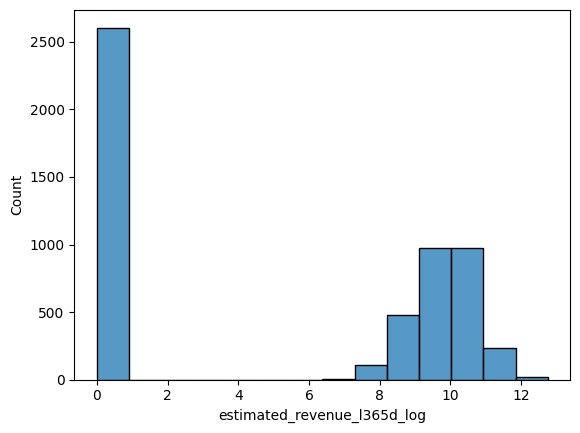

============================================================= BOXPLOT =============================================================


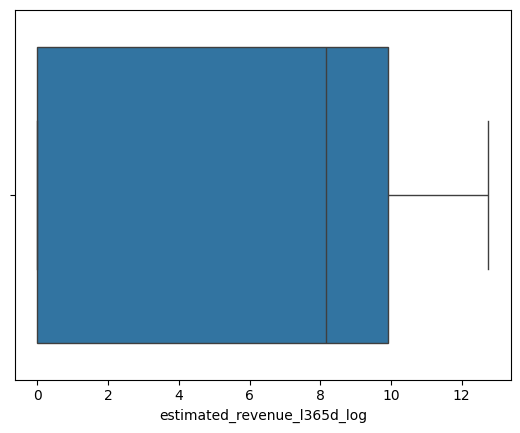

============================================================= SKEWNESS =============================================================
-0.021494347495540404


============================================================= TOP {N} VALUES =============================================================
estimated_revenue_l365d_log
0.000000    2606
9.798183      29
9.105091      20
9.923339      20
9.392745      19
9.287394      19
9.488048      18
8.881975      18
8.476580      17
9.230241      17
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
estimated_revenue_l365d_log
9.692334     1
9.182866     1
10.962336    1
10.571727    1
10.874001    1
10.582054    1
10.918736    1
10.738156    1
10.194701    1
11.016019    1
Name: count, dtype: int64


In [37]:
univariate_analysis(listings, 'estimated_revenue_l365d_log')

Looks like the skewness and outliers issue is resolved here.

##### Now let's look at the columns with Very High Skewness(15 - 40)

In [38]:
len(listings[listings['minimum_nights_avg_ntm'] > 365.0]['minimum_nights_avg_ntm'])

38

i.e. for columns minimum_nights, minimum_minimum_nights,minimum_nights_avg_ntm have 53, 53, & 73 entries with value > 365.0(i.e. 1 year). Such properties can be luxury properties, but since we are currently trying to make prediction mode for day-to-day regular properties, such values will act negatively for our mode. So, it's best to cap these values at 365.0(i.e. 1 year).

In [39]:
night_limit = 365.0

min_night_cols = ['minimum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm']
for col in min_night_cols:
    new_col = col + '_capped'
    listings[new_col] = listings[col].clip(upper=night_limit)

============================================================= DESCRIPTION =============================================================
count    15332.000000
mean        31.583355
std         27.528768
min          1.000000
25%         30.000000
50%         30.000000
75%         30.000000
max        365.000000
Name: minimum_nights_capped, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


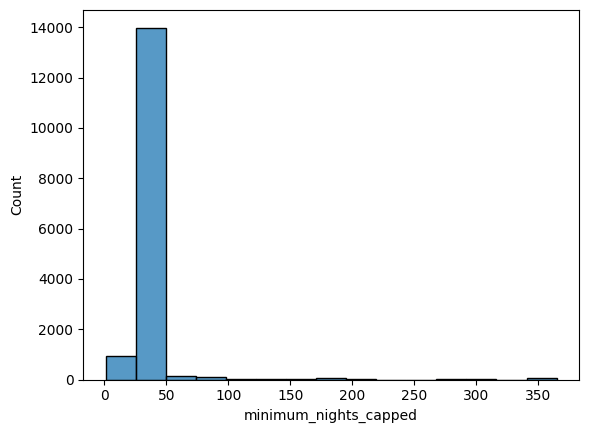

============================================================= BOXPLOT =============================================================


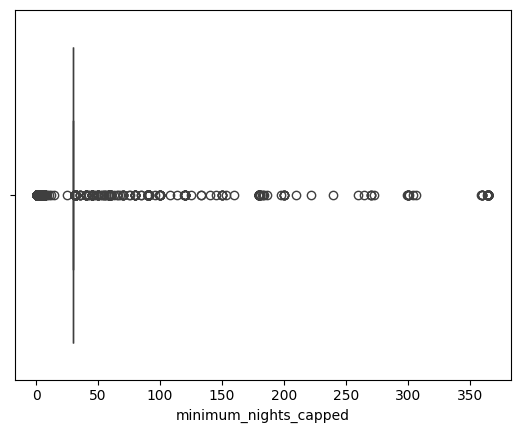

============================================================= SKEWNESS =============================================================
9.52104373842574


============================================================= TOP {N} VALUES =============================================================
minimum_nights_capped
30.0     13663
1.0        348
31.0       285
2.0        223
3.0        189
60.0        96
90.0        88
4.0         73
365.0       61
5.0         60
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
minimum_nights_capped
63.0     1
43.0     1
96.0     1
145.0    1
76.0     1
9.0      1
182.0    1
75.0     1
304.0    1
307.0    1
Name: count, dtype: int64


In [40]:
univariate_analysis(listings, 'minimum_nights_capped')

###### Still the univariate analysis of capped column shows high skewness of 9. Let's try log transforming it and see what happens if it's acceptble then we will do it inplace.

In [41]:
log_transformed = np.log1p(listings['minimum_nights_avg_ntm_capped'])

============================================================= DESCRIPTION =============================================================
count    15332.000000
mean         3.334830
std          0.619382
min          0.693147
25%          3.433987
50%          3.433987
75%          3.433987
max          5.902633
Name: minimum_nights_avg_ntm_capped, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


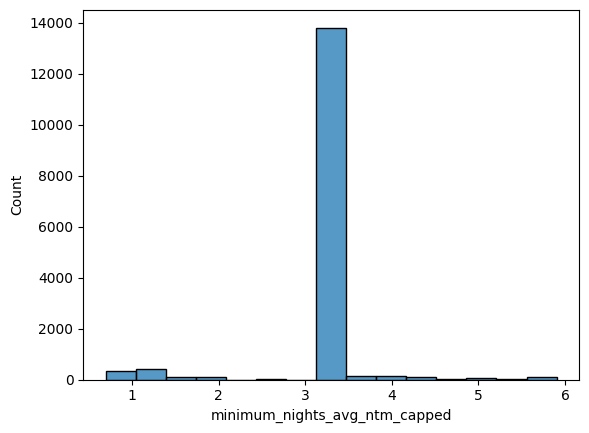

============================================================= BOXPLOT =============================================================


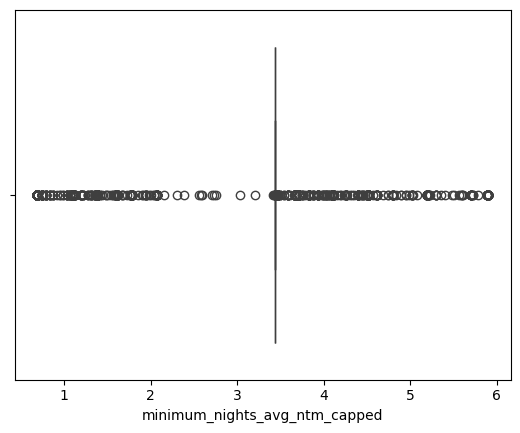

============================================================= SKEWNESS =============================================================
-2.351986037644996


============================================================= TOP {N} VALUES =============================================================
minimum_nights_avg_ntm_capped
3.433987    13616
0.693147      279
1.098612      204
1.386294      167
3.465736      156
4.110874       85
4.510860       82
3.671225       73
5.902633       67
1.609438       67
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
minimum_nights_avg_ntm_capped
2.302585    1
5.209486    1
4.330733    1
5.720312    1
4.109233    1
5.782902    1
3.034953    1
5.730100    1
4.104295    1
1.987874    1
Name: count, dtype: int64


In [42]:
new_df = pd.DataFrame(log_transformed)
univariate_analysis(new_df, 'minimum_nights_avg_ntm_capped')

Looks like the log transformation here will work just fine and the rest of skewness and outliers we are seeing are expected as most proprties have minimum nights of 1 to 30 days.

###### Let's do changes inplace now.

In [43]:
cols = ['minimum_nights_capped', 'minimum_minimum_nights_capped', 'minimum_nights_avg_ntm_capped']
for col in cols:
  listings[col] = np.log1p(listings[col])

In [44]:
listings['minimum_nights_avg_ntm_capped'].skew()

np.float64(-2.351986037644996)

###### now looking at next set of columns:
number_of_reviews_ltm (skewness = 36.29, max = 1786)

number_of_reviews_l30d (skewness = 40.18, max = 153)

number_of_reviews_ly (skewness = 37.76, max = 1797)

reviews_per_month (skewness = 19.99, max = 121.97)

In [45]:
listings['number_of_reviews_ltm'].describe()

count    15332.000000
mean         1.987542
std          8.714620
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        304.000000
Name: number_of_reviews_ltm, dtype: float64

for these columns Skewness and Outliers Are Expected

- Some listings are highly popular or professional (e.g., multi-unit hosts), naturally receiving many more reviews.

- Others are new or low-activity listings with few or no reviews.

- This creates long right tails in data distribution.

Let's try log-transforming them.

============================================================= DESCRIPTION =============================================================
count    12314.000000
mean         0.318517
std          0.392225
min          0.009950
25%          0.039221
50%          0.139762
75%          0.463734
max          3.393501
Name: reviews_per_month, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


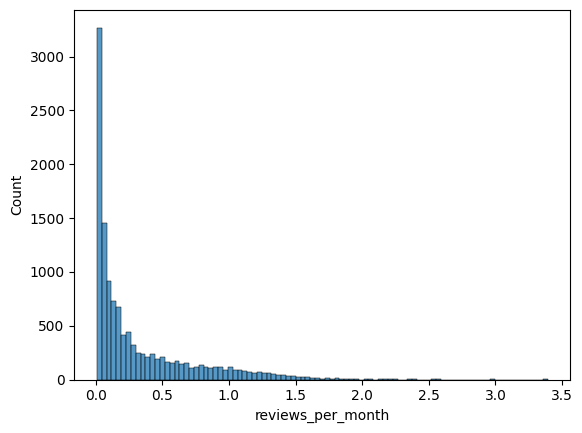

============================================================= BOXPLOT =============================================================


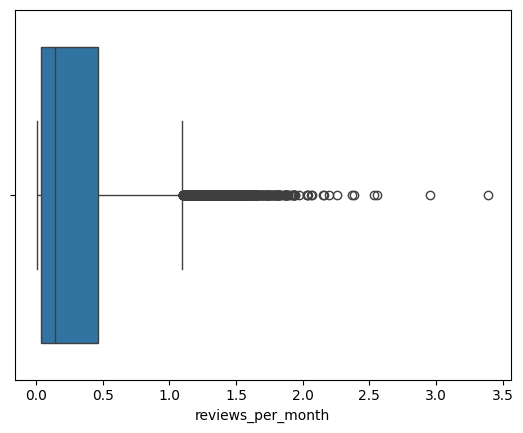

============================================================= SKEWNESS =============================================================
1.684647136527272


============================================================= TOP {N} VALUES =============================================================
reviews_per_month
0.009950    1199
0.019803     875
0.029559     677
0.039221     519
0.048790     435
0.058269     364
0.067659     335
0.076961     318
0.086178     253
0.095310     228
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
reviews_per_month
1.791759    1
1.749200    1
1.731656    1
1.321756    1
1.413423    1
2.066863    1
2.149434    1
1.678964    1
1.566530    1
1.793425    1
Name: count, dtype: int64


In [46]:
log_transformed = np.log1p(listings['reviews_per_month'])
new_df = pd.DataFrame(log_transformed)
univariate_analysis(new_df, 'reviews_per_month')

Looks like the transformed columns are good for model training except for Linear Regression, for that we might have to transform them further using Yeo-Johnson transformation. But till then lest transform the columns in the listings.

In [47]:
cols = ['number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'reviews_per_month']
for col in cols:
  new_col = col + '_log'
  listings[new_col] = np.log1p(listings[col])

###### now let's look at:

calculated_host_listings_count_shared_rooms (skewness = 27.13, max = 17)

In [48]:
listings['calculated_host_listings_count_shared_rooms'].describe()

count    15332.000000
mean         0.015654
std          0.355565
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: calculated_host_listings_count_shared_rooms, dtype: float64

============================================================= DESCRIPTION =============================================================
count    15332.000000
mean         0.006857
std          0.088885
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.890372
Name: calculated_host_listings_count_shared_rooms, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


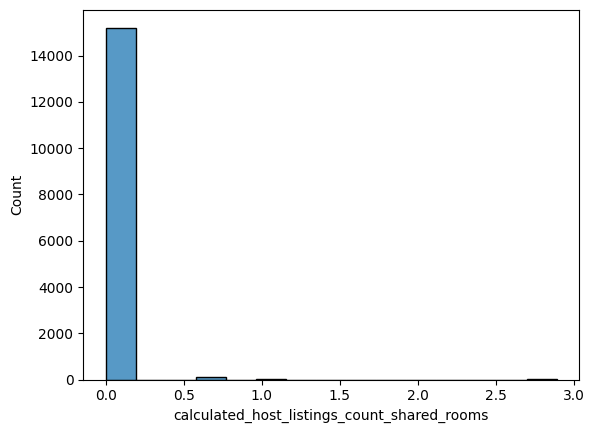

============================================================= BOXPLOT =============================================================


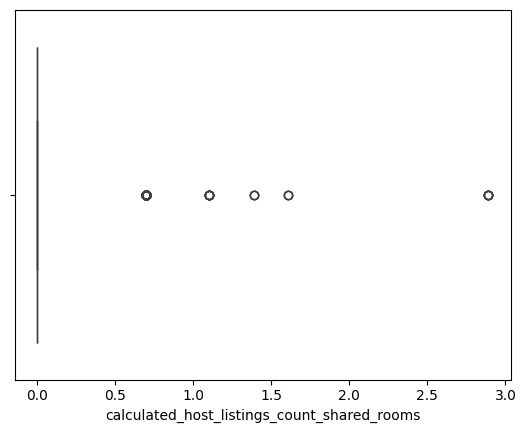

============================================================= SKEWNESS =============================================================
19.241690485885954


============================================================= TOP {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
0.000000    15211
0.693147      101
1.098612        8
2.890372        6
1.609438        3
1.386294        3
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
0.000000    15211
0.693147      101
1.098612        8
2.890372        6
1.609438        3
1.386294        3
Name: count, dtype: int64


In [49]:
log_transformed = np.log1p(listings['calculated_host_listings_count_shared_rooms'])
new_df = pd.DataFrame(log_transformed)
univariate_analysis(new_df, 'calculated_host_listings_count_shared_rooms')

In [50]:
pt = PowerTransformer(method='yeo-johnson')
yj_transformed = pt.fit_transform(listings[['calculated_host_listings_count_shared_rooms']])

# Create DataFrame with the original column name
new_df = pd.DataFrame(yj_transformed, columns=['calculated_host_listings_count_shared_rooms'])
univariate_analysis(new_df, 'calculated_host_listings_count_shared_rooms')

============================================================= DESCRIPTION =============================================================
count    1.533200e+04
mean     2.502564e-17
std      1.000033e+00
min     -8.918951e-02
25%     -8.918951e-02
50%     -8.918951e-02
75%     -8.918951e-02
max      1.121208e+01
Name: calculated_host_listings_count_shared_rooms, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


============================================================= BOXPLOT =============================================================


============================================================= SKEWNESS =============================================================
11.123979086627388


============================================================= TOP {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
-0.08919     15211
 11.21208      121
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
-0.08919     15211
 11.21208      121
Name: count, dtype: int64


For this column I will generate 2 more columns:
1. Where I will not use it in Linear Regression, here I will just YJ Transform it.
2. Where I will use it in LR so I will cap it at 99th percentile and then YJ Transform it.

In [51]:
pt = PowerTransformer(method = 'yeo-johnson')
listings['calculated_host_listings_count_shared_rooms_transformed'] = pt.fit_transform(listings[['calculated_host_listings_count_shared_rooms']])

In [52]:
pt = PowerTransformer(method='yeo-johnson')

upper_limit = listings['calculated_host_listings_count_shared_rooms'].quantile(0.99)
capped = listings['calculated_host_listings_count_shared_rooms'].clip(upper=upper_limit)
print(capped.describe())
print(capped.nunique())
# listings['calculated_host_listings_count_shared_rooms_capped_transformed'] = pt.fit_transform(capped.values.reshape(-1, 1))

count    15332.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: calculated_host_listings_count_shared_rooms, dtype: float64
1


============================================================= DESCRIPTION =============================================================
count    15332.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: calculated_host_listings_count_shared_rooms, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


============================================================= BOXPLOT =============================================================


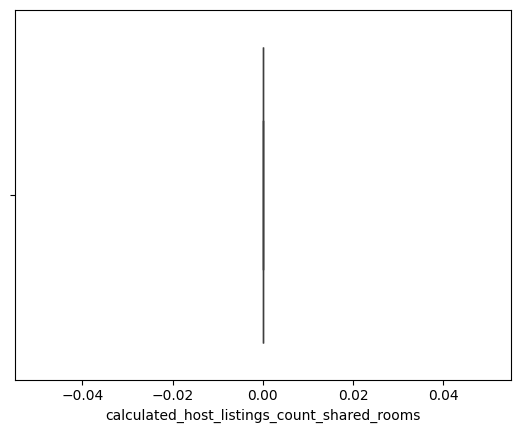

============================================================= SKEWNESS =============================================================
0.0


============================================================= TOP {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
0.0    15332
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
calculated_host_listings_count_shared_rooms
0.0    15332
Name: count, dtype: int64


In [53]:
new_df = pd.DataFrame(capped)
univariate_analysis(new_df, 'calculated_host_listings_count_shared_rooms')

Looks like capping here is illogical so we **cannot use this column in LR**.

##### Now let's look at these set of columns with Moderate High Skewness:

beds (skewness = 4.18, max = 40)

calculated_host_listings_count_entire_homes (skewness = 4.19, max = 1054)

bedrooms (skewness = 2.18, max = 15)

accommodates (skewness = 2.67, max = 13)

In [54]:
listings.bedrooms.skew()

np.float64(2.628824480086281)

In [55]:
new_beds = listings['calculated_host_listings_count_entire_homes']
new_beds[new_beds == 0] = 1
new_beds

/tmp/ipython-input-1888202237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_beds[new_beds == 0] = 1


0        1.0
1        3.0
2        1.0
3        1.0
4        1.0
        ... 
15393    1.0
15394    1.0
15395    4.0
15396    1.0
15397    NaN
Name: calculated_host_listings_count_entire_homes, Length: 15333, dtype: float64

In [56]:
new_beds.skew()

np.float64(10.285561252684076)

============================================================= DESCRIPTION =============================================================
count    15332.000000
mean         0.903668
std          0.828988
min          0.693147
25%          0.693147
50%          0.693147
75%          0.693147
max          6.961296
Name: calculated_host_listings_count_entire_homes, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


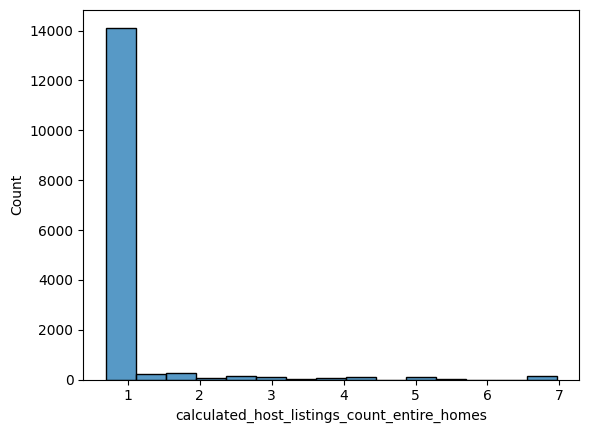

============================================================= BOXPLOT =============================================================


============================================================= SKEWNESS =============================================================
5.23243037840819


============================================================= TOP {N} VALUES =============================================================
calculated_host_listings_count_entire_homes
0.693147    13483
1.098612      638
1.386294      210
1.609438      133
6.961296      130
1.945910       64
5.198497       60
1.791759       58
2.833213       50
4.304065       40
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
calculated_host_listings_count_entire_homes
2.484907    18
5.472271    18
4.143135    18
2.708050    14
3.258097    13
2.302585    13
3.784190    12
4.897840    12
2.995732     7
2.564949     1
Name: count, dtype: int64


In [57]:
log_beds = np.log1p(listings['calculated_host_listings_count_entire_homes'])
new_df = pd.DataFrame(log_beds)
univariate_analysis(new_df, 'calculated_host_listings_count_entire_homes')

beds = 0 doesn't make any sense as any apartment has atleast one bed to slee on and seeing the description of such entries it's pretty obvious that these entries are wrong.

In [58]:
listings.loc[listings['room_type'] == 0, 'beds'] = 1
listings['beds_log'] = np.log1p(listings['beds'])

calculated_host_listings_count_entire_homes column is log-transformed so that we can use it in models other than LR. In LR we **won't be using this feature**.

In [59]:
listings['calculated_host_listings_count_entire_homes_log'] = np.log1p(listings['calculated_host_listings_count_entire_homes'])

For bedrooms column the room_type = entire homes/apartments listings should have atleast 1 bed also we need to log transform so that we can remove skewness.

**FEATURE ENGINEERING: isStudio() flag column** where bedroom == 0 and room_type == Private room

In [60]:
listings.loc[listings['room_type'] == 'entire homes/apartments', 'bedrooms'] = 1

In [61]:
listings['bedrooms_log'] = np.log1p(listings['bedrooms'])

In [62]:
listings.bedrooms_log.skew()

np.float64(0.28295696456219716)

============================================================= DESCRIPTION =============================================================
count    11143.000000
mean         0.801980
std          0.309751
min          0.000000
25%          0.693147
50%          0.693147
75%          1.098612
max          2.708050
Name: bedrooms_log, dtype: float64


============================================================= MISSING DATA =============================================================
============================================================= HISTOGRAM =============================================================


============================================================= BOXPLOT =============================================================


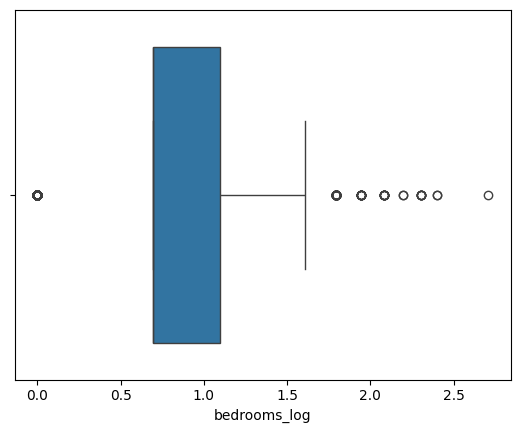

============================================================= SKEWNESS =============================================================
0.28295696456219716


============================================================= TOP {N} VALUES =============================================================
bedrooms_log
0.693147    7429
1.098612    2311
1.386294     594
0.000000     561
1.609438     165
1.791759      51
1.945910      12
2.079442       9
2.302585       6
2.397895       2
Name: count, dtype: int64
============================================================= BOTTOM {N} VALUES =============================================================
bedrooms_log
1.386294    594
0.000000    561
1.609438    165
1.791759     51
1.945910     12
2.079442      9
2.302585      6
2.397895      2
2.197225      2
2.708050      1
Name: count, dtype: int64


In [63]:
univariate_analysis(listings, 'bedrooms_log')

In [64]:
listings.accommodates.describe()

count    15332.000000
mean         2.635468
std          1.665992
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: accommodates, dtype: float64

We just need to transform accommodate.

In [65]:
listings['accommodates_log'] = np.log1p(listings['accommodates'])

### IMPUTING

**Columns with High Missing Values (>15%):**

beds (40.476% missing)

estimated_revenue_l365d (40.92% missing)

review_scores_rating (30.70% missing)

review_scores_accuracy (30.72% missing)

review_scores_cleanliness (30.70% missing)

review_scores_checkin (30.74% missing)

review_scores_communication (30.72% missing)

review_scores_location (30.75% missing)

reviews_per_month (30.70% missing)

bedrooms (16.65% missing)

neighbourhood (47.46% missing)

has_availability (15.46% missing)

#### IMPUTING NUMERICAL COLUMNS

In [66]:
missing_data.loc[numerical_columns][missing_data.loc[numerical_columns] > 0].sort_values(by='Total_Nan')

Total_Nan      %_Nan
latitude                                            1.0   0.006494
longitude                                           1.0   0.006494
accommodates                                        1.0   0.006494
minimum_nights                                      1.0   0.006494
minimum_minimum_nights                              1.0   0.006494
maximum_nights                                      1.0   0.006494
minimum_maximum_nights                              1.0   0.006494
maximum_minimum_nights                              1.0   0.006494
maximum_nights_avg_ntm                              1.0   0.006494
availability_30                                     1.0   0.006494
maximum_maximum_nights                              1.0   0.006494
minimum_nights_avg_ntm                              1.0   0.006494
availability_60                                     1.0   0.006494
availability_90                                     1.0   0.006494
number_of_reviews                                   1.0   0.006494
availability_365                                    1.0   0.006494
availability_eoy                                    1.0   0.006494
number_of_reviews_ly                                1.0   0.006494
number_of_reviews_ltm                               1.0   0.006494
number_of_reviews_l30d                              1.0   0.006494
estimated_occupancy_l365d                           1.0   0.006494
calculated_host_listings_count                      1.0   0.006494
calculated_host_listings_count_private_rooms        1.0   0.006494
calculated_host_listings_count_entire_homes         1.0   0.006494
calculated_host_listings_count_shared_rooms         1.0   0.006494
reviews_per_month                                3035.0  19.710352
review_scores_rating                             3035.0  19.710352
review_scores_cleanliness                        3036.0  19.716846
review_scores_communication                      3041.0  19.749318
review_scores_accuracy                           3045.0  19.775295
review_scores_checkin                            3049.0  19.801273
review_scores_location                           3051.0  19.814262
review_scores_value                              3051.0  19.814262
bedrooms                                         4196.0  27.250292
beds                                             9926.0  64.462917
estimated_revenue_l365d                          9977.0  64.794129
id                                                  NaN        NaN
host_id                                             NaN        NaN

We can impute column with 1 value missing with median..

In [67]:
def impute_small_missing(df, column_name, strategy='median'):
    if df[column_name].isnull().sum() > 0:
        if strategy == 'median':
            fill_value = df[column_name].median()
        elif strategy == 'mean':
            fill_value = df[column_name].mean()
        else:
            raise ValueError("Strategy must be 'median' or 'mean'")

        df[column_name] = df[column_name].fillna(fill_value)
        print(f"Imputed missing values in '{column_name}' with {strategy} = {fill_value}")
    else:
        print(f"No missing values to impute in '{column_name}'")


In [68]:
column_names = [
    'accommodates',
    'minimum_nights',
    'maximum_minimum_nights',
    'minimum_minimum_nights',
    'maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'minimum_maximum_nights',
    'availability_30',
    'availability_365',
    'availability_90',
    'availability_60',
    'estimated_occupancy_l365d',
    'number_of_reviews_l30d',
    'availability_eoy',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_ly',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count',
    'calculated_host_listings_count_shared_rooms',
    'minimum_nights_avg_ntm_capped',
    'minimum_minimum_nights_capped',
    'minimum_nights_capped',
    'calculated_host_listings_count_private_rooms'
]


In [69]:
for col in column_names:
    impute_small_missing(listings, col)

Imputed missing values in 'accommodates' with median = 2.0
Imputed missing values in 'minimum_nights' with median = 30.0
Imputed missing values in 'maximum_minimum_nights' with median = 30.0
Imputed missing values in 'minimum_minimum_nights' with median = 30.0
Imputed missing values in 'maximum_nights' with median = 1125.0
Imputed missing values in 'maximum_maximum_nights' with median = 1125.0
Imputed missing values in 'minimum_nights_avg_ntm' with median = 30.0
Imputed missing values in 'maximum_nights_avg_ntm' with median = 1125.0
Imputed missing values in 'minimum_maximum_nights' with median = 1125.0
Imputed missing values in 'availability_30' with median = 0.0
Imputed missing values in 'availability_365' with median = 0.0
Imputed missing values in 'availability_90' with median = 0.0
Imputed missing values in 'availability_60' with median = 0.0
Imputed missing values in 'estimated_occupancy_l365d' with median = 0.0
Imputed missing values in 'number_of_reviews_l30d' with median = 0.0

In [70]:
lat_median = listings['latitude'].median()
lon_median = listings['longitude'].median()

listings['latitude'].fillna(lat_median, inplace=True)
listings['longitude'].fillna(lon_median, inplace=True)

/tmp/ipython-input-1595142641.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings['latitude'].fillna(lat_median, inplace=True)
/tmp/ipython-input-1595142641.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Imputing Other Numerical Columns

In [71]:
def evaluate_imputation_with_method(df, column_name, imputer_type='iterative', strategy='median', n_neighbors=5, missing_frac=0.1, random_state=42):
    """
    Evaluates imputation quality by masking part of the data, imputing with specified method,
    and comparing imputed values to original values via RMSE.

    Parameters:
    - df: pandas DataFrame containing no missing values in column_name
    - column_name: str, target column to impute and evaluate
    - imputer_type: str, one of ['iterative', 'knn', 'simple'] (default='iterative')
    - strategy: str, for SimpleImputer, ['mean', 'median'] (default='median')
    - n_neighbors: int, for KNN imputer (default=5)
    - missing_frac: float, fraction of data to mask as missing (default=0.1)
    - random_state: int for reproducibility (default=42)

    Returns:
    - rmse: float, root mean squared error of imputation
    """
    # Copy and mask data
    data = df[[column_name]].copy()
    np.random.seed(random_state)
    mask = np.random.rand(len(data)) < missing_frac
    data_missing = data.copy()
    data_missing.loc[mask, column_name] = np.nan

    # Choose imputer
    if imputer_type == 'iterative':
        imputer = IterativeImputer(random_state=random_state, max_iter=10)
    elif imputer_type == 'knn':
        imputer = KNNImputer(n_neighbors=n_neighbors)
    elif imputer_type == 'simple':
        imputer = SimpleImputer(strategy=strategy)
    else:
        raise ValueError("imputer_type must be one of ['iterative', 'knn', 'simple']")

    # Impute missing data
    imputed_array = imputer.fit_transform(data_missing)
    imputed_series = pd.Series(imputed_array.flatten(), index=df.index)

    # Calculate RMSE on masked entries
    rmse = np.sqrt(mean_squared_error(df.loc[mask, column_name], imputed_series.loc[mask]))

    # Plot distributions
    plt.figure(figsize=(10,5))
    plt.hist(df[column_name], bins=30, alpha=0.5, label='Original')
    plt.hist(imputed_series, bins=30, alpha=0.5, label='Imputed')
    plt.title(f'Distribution Comparison for {column_name} ({imputer_type} imputer)')
    plt.legend()
    plt.show()

    print(f'RMSE for {column_name} imputation with {imputer_type} imputer: {rmse:.4f}')
    return rmse

In [72]:
cols = [
    "bedrooms_log",
    "review_scores_rating",
    "reviews_per_month_log",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_accuracy",
    "review_scores_checkin",
    "review_scores_value",
    "review_scores_location",
    "beds_log",
    "estimated_revenue_l365d_log",
    "price"
]


In [73]:
no_missing_df = listings.dropna(subset=['price'])

# Evaluate imputation quality
evaluate_imputation_with_method(no_missing_df, 'price', 'knn', missing_frac=0.1)

RMSE for price imputation with knn imputer: 204.0335


np.float64(204.0334827506826)

As we can see price which is our target column has 44% missing values. So we have no choice but to delete these rows.

In [74]:
# Drop rows where target column 'price' is missing
listings = listings.dropna(subset=['price'])

# Reset index after dropping
listings = listings.reset_index(drop=True)

print("Remaining rows:", len(listings))


Remaining rows: 5396


Let's impute the bedrooms and beds column and recaliberate their log columns

In [75]:
# Impute original columns
listings['bedrooms'] = listings['bedrooms'].fillna(listings['bedrooms'].median())
listings['beds'] = listings['beds'].fillna(listings['beds'].median())

# Recompute log versions (adding +1 in case of 0 to avoid log(0))
listings['bedrooms_log'] = np.log1p(listings['bedrooms'])
listings['beds_log'] = np.log1p(listings['beds'])


What I think we should do with the columns

['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

 is that we should fill reviews_per_month as 0 as all others with median of their respective columns. After that we will also create a missing indicator for them.

In [76]:
# reviews_per_month -> 0 if missing
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

# numeric review scores
review_cols = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

for col in review_cols:
    listings[col + '_missing'] = listings[col].isna().astype(int)   # indicator
    listings[col] = listings[col].fillna(listings[col].median())   # median imputation


In [77]:
listings['reviews_per_month_log'] = np.log1p(listings['reviews_per_month'])

#### IMPUTING CATEGORICAL COLUMNS

In [78]:
missing_data.loc[categorical_columns][missing_data.loc[categorical_columns] > 0].sort_values(by='Total_Nan')

Total_Nan      %_Nan
room_type                      1   0.006494
instant_bookable               1   0.006494
calendar_last_scraped          1   0.006494
amenities                      1   0.006494
name                           2   0.012989
host_name                      8   0.051955
host_is_superhost            108   0.701390
description                  583   3.786206
last_review                 3035  19.710352
first_review                3035  19.710352
has_availability            4727  30.698792
neighbourhood               5505  35.751396
neighborhood_overview       5506  35.757891
host_about                  5962  38.719314
price                       9977  64.794129

In [79]:
listings.neighborhood_overview.describe()

count                                                  4104
unique                                                 3615
top       We're located in a safe and quiet residential ...
freq                                                     30
Name: neighborhood_overview, dtype: object

**FEATURE ENGINEERING: we will construct days_since_first_review, days_since_last_revie from first_review and last_review**

In [80]:
mask = listings['has_availability'].isna()
listings.loc[mask, 'has_availability'] = listings.loc[mask, 'availability_30'].apply(
    lambda x: 'f' if x == 0 else 't'
)

In [81]:
missing_data[
    (missing_data['Total_Nan'] > 0) &
    (missing_data['Total_Nan'].notna())
]

Total_Nan      %_Nan
price                                              9977  64.794129
estimated_revenue_l365d                            9977  64.794129
beds                                               9926  64.462917
host_about                                         5962  38.719314
neighborhood_overview                              5506  35.757891
neighbourhood                                      5505  35.751396
has_availability                                   4727  30.698792
bedrooms                                           4196  27.250292
review_scores_location                             3051  19.814262
review_scores_value                                3051  19.814262
review_scores_checkin                              3049  19.801273
review_scores_accuracy                             3045  19.775295
review_scores_communication                        3041  19.749318
review_scores_cleanliness                          3036  19.716846
first_review                                       3035  19.710352
reviews_per_month                                  3035  19.710352
review_scores_rating                               3035  19.710352
last_review                                        3035  19.710352
description                                         583   3.786206
host_is_superhost                                   108   0.701390
host_name                                             8   0.051955
name                                                  2   0.012989
estimated_occupancy_l365d                             1   0.006494
maximum_minimum_nights                                1   0.006494
number_of_reviews_ly                                  1   0.006494
amenities                                             1   0.006494
longitude                                             1   0.006494
maximum_nights                                        1   0.006494
minimum_nights                                        1   0.006494
latitude                                              1   0.006494
accommodates                                          1   0.006494
room_type                                             1   0.006494
minimum_minimum_nights                                1   0.006494
maximum_nights_avg_ntm                                1   0.006494
minimum_maximum_nights                                1   0.006494
minimum_nights_avg_ntm                                1   0.006494
maximum_maximum_nights                                1   0.006494
availability_90                                       1   0.006494
availability_60                                       1   0.006494
availability_eoy                                      1   0.006494
number_of_reviews_l30d                                1   0.006494
number_of_reviews_ltm                                 1   0.006494
number_of_reviews                                     1   0.006494
calendar_last_scraped                                 1   0.006494
availability_365                                      1   0.006494
calculated_host_listings_count                        1   0.006494
calculated_host_listings_count_entire_homes           1   0.006494
availability_30                                       1   0.006494
instant_bookable                                      1   0.006494
calculated_host_listings_count_private_rooms          1   0.006494
calculated_host_listings_count_shared_rooms           1   0.006494

In [82]:
listings.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_about', 'host_is_superhost', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_lo

## **Adding neighbourhood data**

In [83]:
len(listings.id.unique())

5396

In [84]:
listings.shape

(5396, 73)

In [85]:
cols = ["id", "neighbourhood_cleansed"]
raw_data = pd.read_csv("/content/listings_NewYork.csv", usecols = cols)

In [86]:
raw_data.shape

(36322, 2)

In [87]:
listings = listings.merge(raw_data, on="id", how="left")

## **BIVARIATE ANALYSIS**

### **TOP AREAS WITH HIGHEST NUMBER OF LISTINGS**

Since neighbourhood is no use and convert neighbourhood_cleansed to neighbourhood

In [88]:
listings.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_about', 'host_is_superhost', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_lo

In [89]:
# Drop the messy 'neighbourhood'
listings = listings.drop(columns=['neighbourhood'])

# Rename 'neighbourhood_cleansed' to 'neighbourhood'
listings = listings.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})

In [90]:
listings['neighbourhood'].value_counts()

neighbourhood
Bedford-Stuyvesant    404
Harlem                358
Williamsburg          241
Upper East Side       223
Upper West Side       206
                     ... 
Prince's Bay            1
Navy Yard               1
Emerson Hill            1
Bull's Head             1
Bergen Beach            1
Name: count, Length: 196, dtype: int64

In [91]:
np = listings['neighbourhood'].value_counts()
np_1 = np.head(10)
print(np_1)
df_1 = listings[listings['neighbourhood'].isin(np_1.index.tolist())]
sns.set_theme(style="darkgrid")
f,plt_1 = plt.subplots(figsize=(15,6))
plt_2 = sns.countplot(x = "neighbourhood", data = df_1, palette= "muted")
plt.show()

neighbourhood
Bedford-Stuyvesant    404
Harlem                358
Williamsburg          241
Upper East Side       223
Upper West Side       206
Hell's Kitchen        188
Midtown               176
Crown Heights         175
Bushwick              161
East Village          126
Name: count, dtype: int64


/tmp/ipython-input-1954917062.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt_2 = sns.countplot(x = "neighbourhood", data = df_1, palette= "muted")


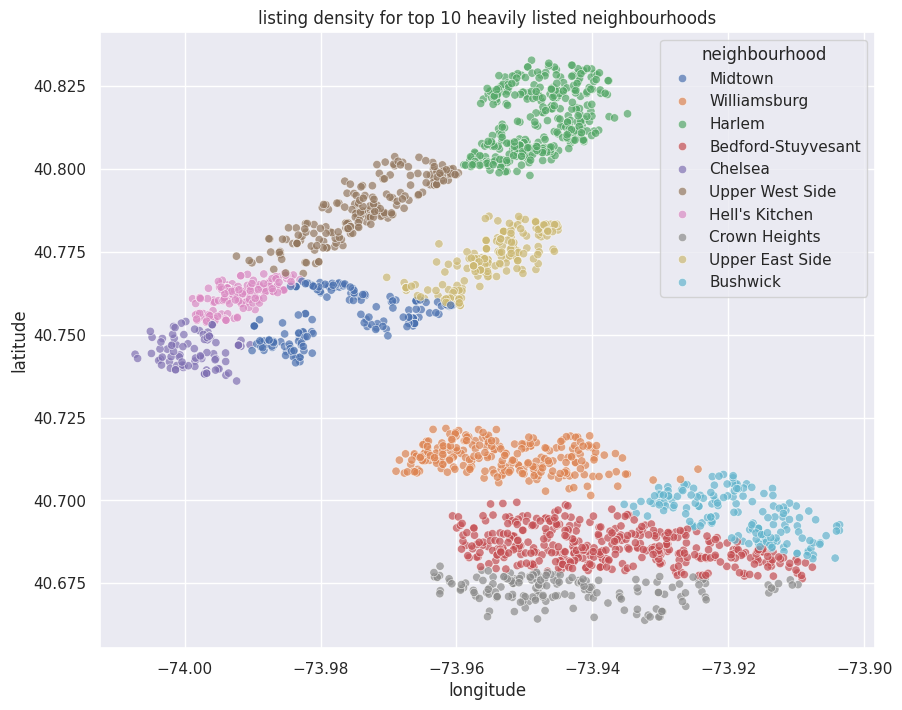

In [92]:
np_1.to_frame()
np_1 = pd.DataFrame(np_1, columns=['neighbourhood'])
np_1.reset_index(level=0, inplace=True)
np_1.rename(columns={'index':'neighbourhood', 'neighbourhood':'listing'})

np_2 = listings.loc[listings['neighbourhood'].isin(['Midtown','Bedford-Stuyvesant', "Hell's Kitchen", 'Upper East Side', 'Harlem', 'Williamsburg','Upper West Side', 'Bushwick', 'Crown Heights', 'Chelsea'])]

np_3 = np_2[['neighbourhood','latitude', 'longitude']]

plt.figure(figsize=(10,8))

g = sns.scatterplot(data=np_3, y="latitude", x="longitude", hue="neighbourhood", alpha=0.7)
g.set_title('listing density for top 10 heavily listed neighbourhoods');

### **TOP 10 HOSTS BY THE TOTAL NUMBER OF LISTINGS**

In [93]:
arr_2 = listings.host_name.value_counts().head(10)

sns.set_theme(style="darkgrid")
f,plt_2 = plt.subplots(figsize=(16,5))
plt_2 = sns.barplot(x = arr_2.index, y= arr_2.values, palette="muted")
plt_2.set_ylabel('Count of listings')
plt_2.set_xlabel('Host Names')
plt_2.set_title('Top 10 hosts')
plt.show()

/tmp/ipython-input-2809060006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt_2 = sns.barplot(x = arr_2.index, y= arr_2.values, palette="muted")


### **PRICES AND NEIGHBOURHOODS & PRICES AND ROOM_TYPE - ANALYSIS**

In [94]:
df_5 = listings.groupby('neighbourhood')['price'].mean()

In [95]:
df_5.to_frame()
df_5.sort_values(inplace=True, ascending=False)
print(df_5.head(5))

neighbourhood
Sea Gate           2029.000000
Fort Wadsworth      600.000000
Stuyvesant Town     592.666667
Fieldston           540.000000
SoHo                500.612903
Name: price, dtype: float64


In [96]:
n_group = pd.DataFrame(df_5, columns = ['price'])
n_group.reset_index(level=0, inplace=True)

/tmp/ipython-input-28087590.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt_3 =sns.barplot(x=X, y=Y, data=n_group,


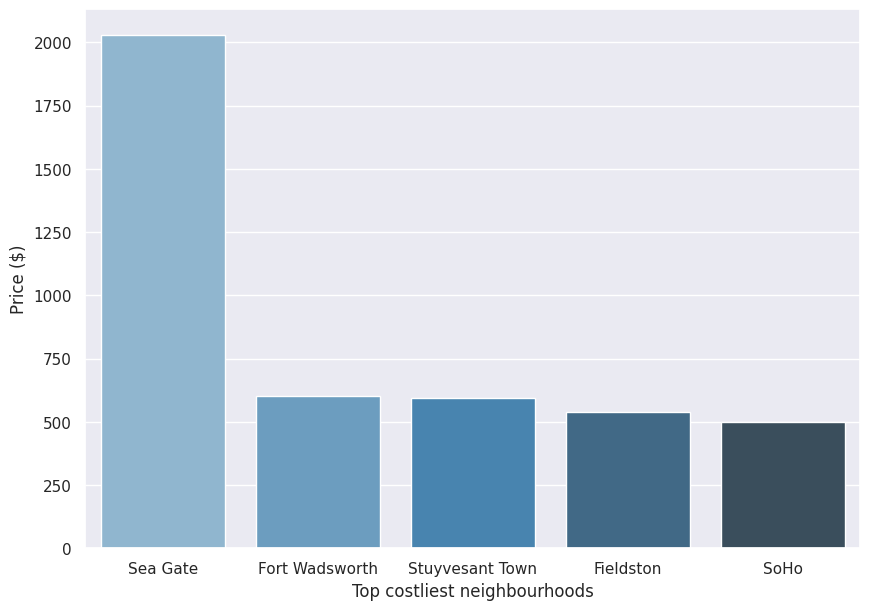

In [97]:
X = n_group['neighbourhood'].head(5)
Y = n_group['price'].head(5)

fig = plt.figure(figsize =(10, 7))

plt_3 =sns.barplot(x=X, y=Y, data=n_group,
                 palette='Blues_d')
plt_3.set_ylabel('Price ($)')
plt_3.set_xlabel('Top costliest neighbourhoods')

plt.show()

In [98]:
listings.price.quantile(0.94)

np.float64(478.2999999999993)

Prices heatmap across entire region for all listings. Removing extreme values i.e > $600

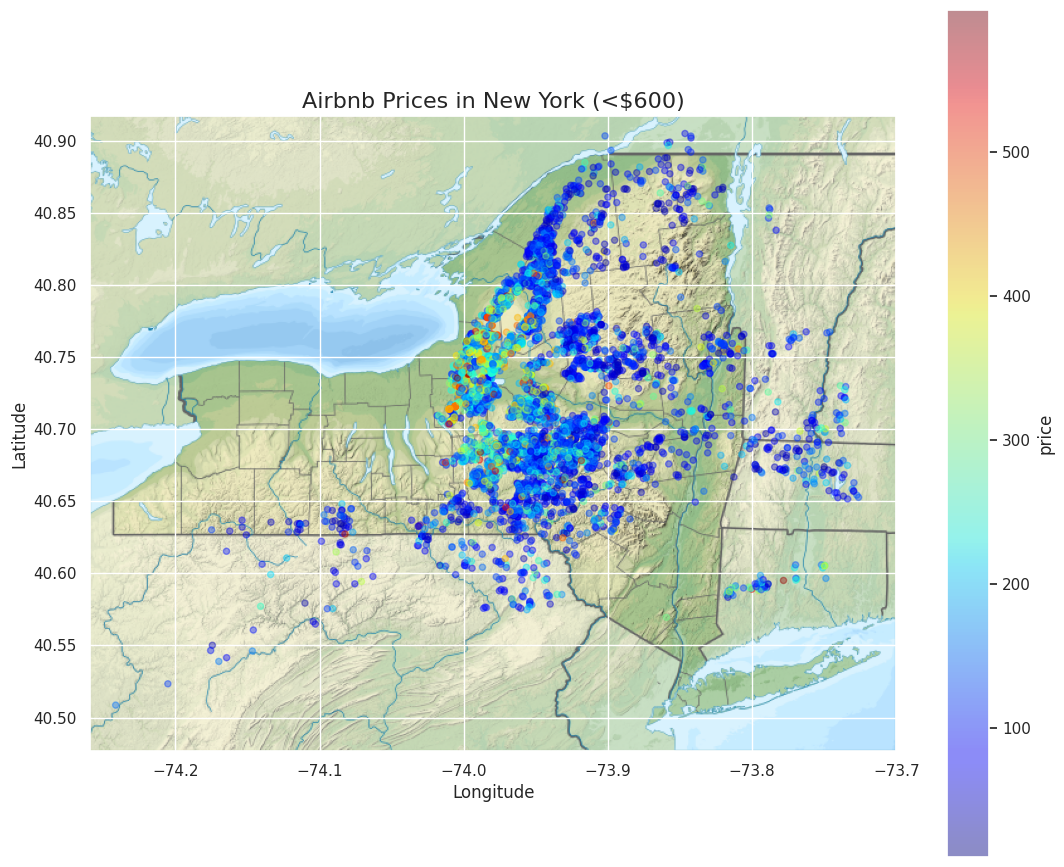

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

# Filter the dataset to remove extreme prices
mp1 = listings[listings['price'] < 600]

# Open the local NYC map image
ny_img = Image.open("/content/New_York.png")
ny_img = np.array(ny_img)

# Plot the image and data
plt.figure(figsize=(13, 11))
plt.imshow(ny_img, zorder=0,
           extent=[-74.259, -73.700, 40.477, 40.917])  # NYC bounding box

ax = plt.gca()

# Scatter plot of listings
mp1.plot.scatter(
    x='longitude',
    y='latitude',
    c='price',
    ax=ax,
    cmap='jet',
    colorbar=True,
    alpha=0.4
)

plt.title("Airbnb Prices in New York (<$600)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Let us look at the regions with their most frequent type of room listings

In [100]:
from urllib.request import urlopen
import json
import plotly.express as px

with urlopen('https://raw.githubusercontent.com/ChiragHooda/Airbnb_Analysis/main/neighbourhoods_geojson_New_York.geojson') as response:
    map_chic = json.load(response)

print(listings["neighbourhood"][0])
print(map_chic['features'][0]["properties"])

fig = px.choropleth_mapbox(listings, geojson=map_chic, color="room_type",
                           locations="neighbourhood", featureidkey="properties.neighbourhood",
                           center={"lat": 40.7128, "lon": -74.0060},
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Kensington
{'neighbourhood': 'Bayswater', 'neighbourhood_group': 'Queens'}


/tmp/ipython-input-3919849849.py:1: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



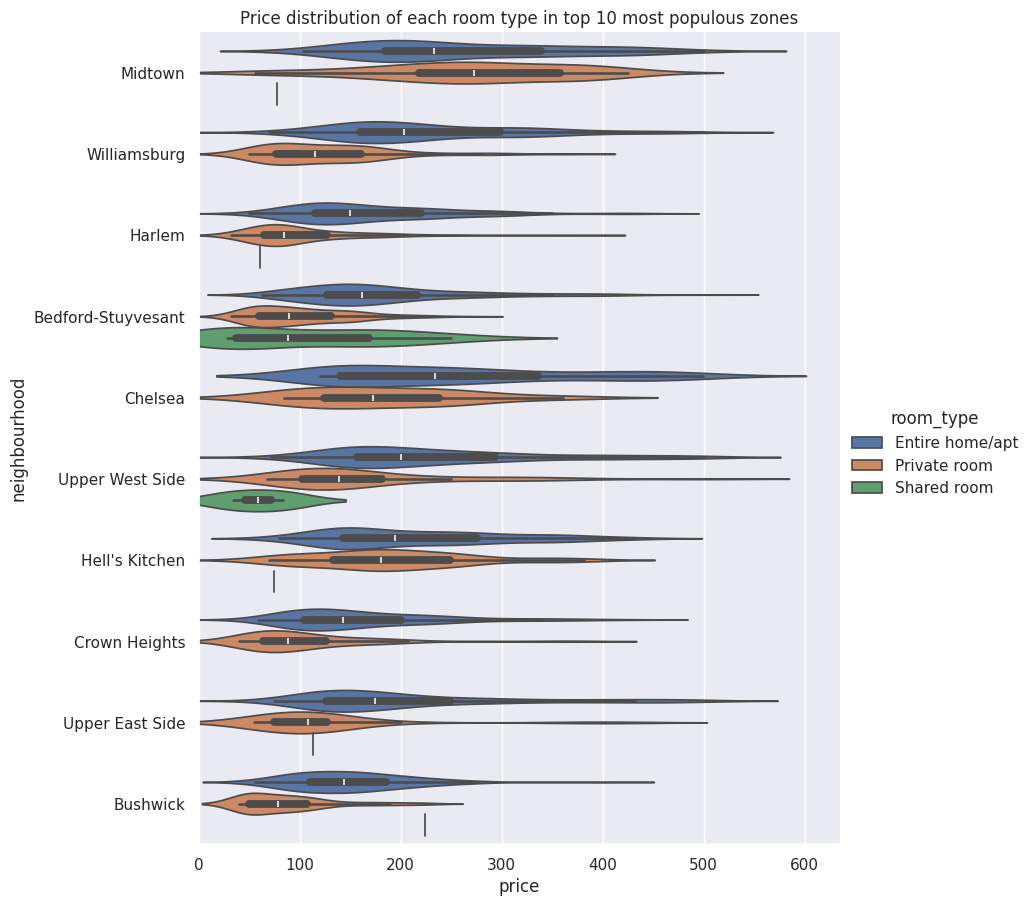

In [101]:
f = sns.catplot(x="price", y="neighbourhood", hue="room_type", data=np_2[np_2['price'] <= 500], scale="width", kind='violin', height=9)
f.axes[0][0].set_xlim(0,)
plt.title('Price distribution of each room type in top 10 most populous zones')
plt.show()

Lastly, to infer better, let us plot the prices for these neighbourhoods with various inherently dependent features that we have in the data-set:



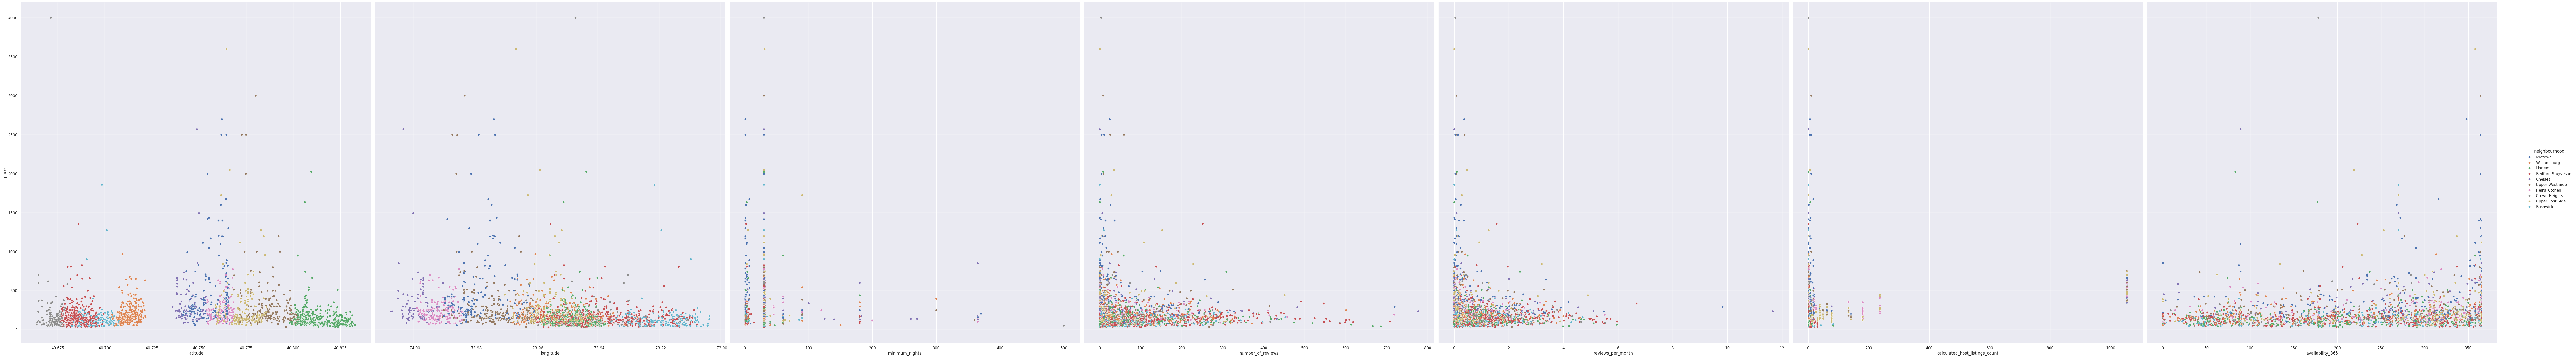

In [102]:
corr_img = sns.pairplot(np_2, y_vars=['price'],
             x_vars=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'],
             height=15, hue='neighbourhood')
corr_img.savefig("output.png")

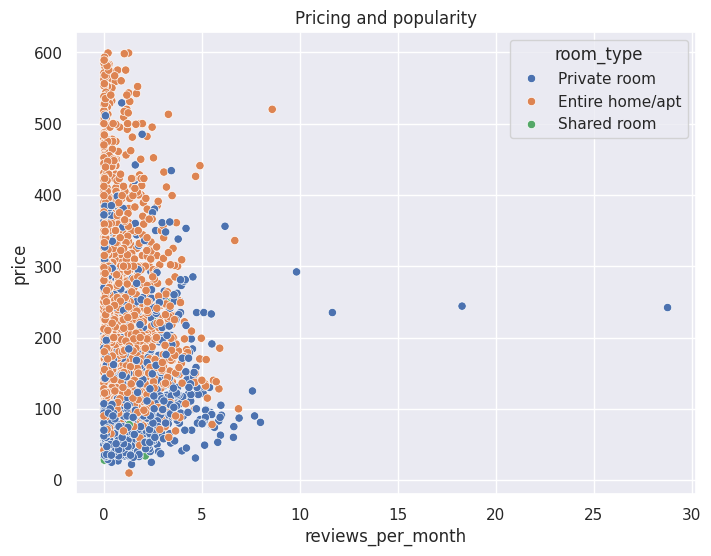

In [103]:
plt.figure(figsize=(8,6))
f = sns.scatterplot(x="reviews_per_month", y='price', hue='room_type', data=listings[listings['price']<600])
f.set_title('Pricing and popularity');

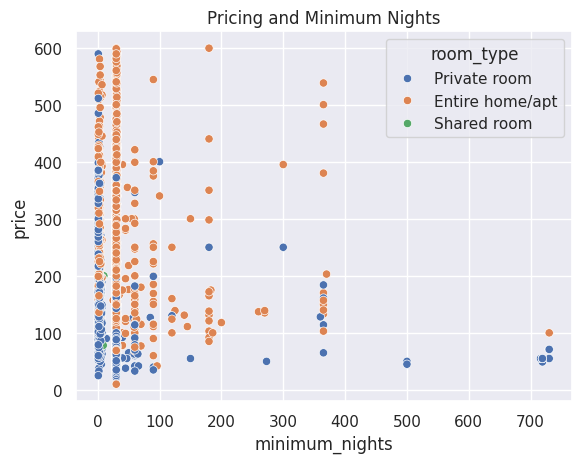

In [104]:
h = sns.scatterplot(x = 'minimum_nights', y = 'price', hue = 'room_type', data = listings[listings.price < 600])
plt.title('Pricing and Minimum Nights');

In [105]:
listings[(listings.room_type == 'Hotel room')].price.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

<Axes: xlabel='room_type', ylabel='price'>

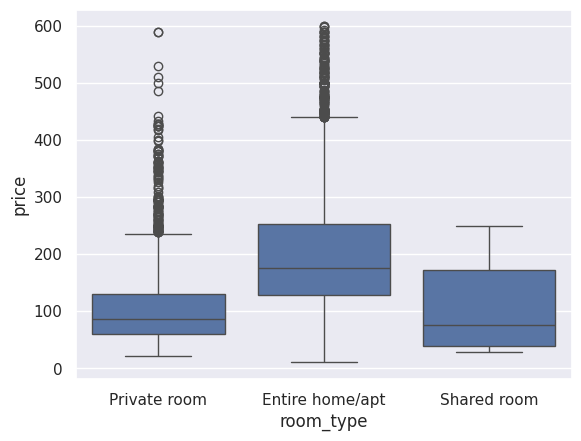

In [106]:
sns.boxplot(x = 'room_type', y = 'price', data = listings[listings.price < 600])

We can conlude from this section that:

- Entire apartment Airbnb are the most costliest ones, while also being the most heavily listed
- Shared homes are cheaper, less frequently listed but feature in a couple of the densely listed neighbourhoods, which are major city centres
- More reviewed, hence popular listings are cheaper than others. Entire apartment listings are quite variable but it does stick to the aforementioned trend more often than not. You will only find entire apartment listings which are also decently popular on the higher end of costs. We can explore a price prediction on the basis of these features
- As the minimum days of stay increases, the cost decreases exponentially.

### **ANALYSING DESCRIPTIONS**

Let's start by looking at the most common words/phrases that are listed in the names of the Airbnbs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


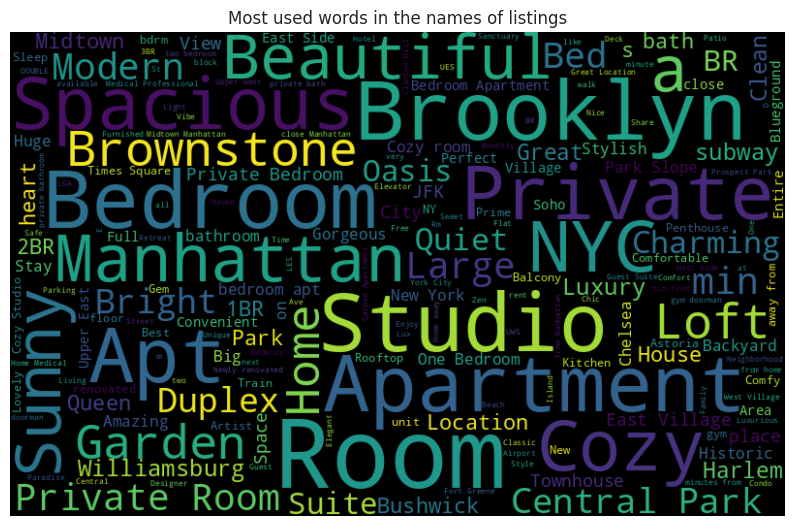

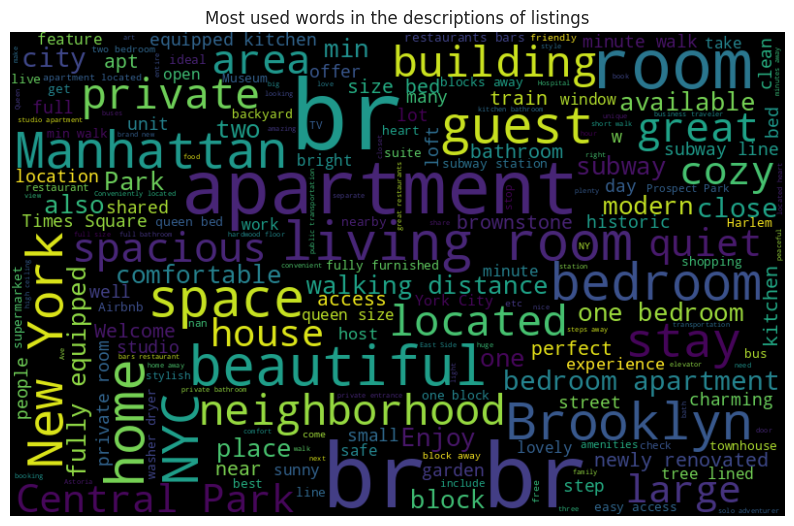

In [107]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- new in NLTK 3.9
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import functools
# Sample stop words
omit_words = {'by', 'the', 'to', 'for', 'with', 'in', 'near', 'your', 'w', 'and', 'of'}

# First WordCloud for 'name' column
fig, ax = plt.subplots(figsize=(10,7))
text = functools.reduce(lambda a, b: a + " " + str(b), listings.sample(frac=0.3)['name'])

# Tokenize and remove omit words
text_tokens = [w for w in nltk.word_tokenize(text) if w.lower() not in omit_words]
new_stopwords = omit_words.union(text_tokens)  # This step is not necessary; just use `omit_words` in WordCloud

wc = WordCloud(width=800, height=500, max_font_size=100, background_color="black",
               stopwords=omit_words).generate(' '.join(text_tokens))
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most used words in the names of listings")
plt.axis("off")
plt.show()

# Second WordCloud for 'description' column
fig, ax = plt.subplots(figsize=(10,7))
stop_2 = set(stopwords.words('english'))
text = functools.reduce(lambda a, b: a + " " + str(b), listings.sample(frac=0.3)['description'])

# Tokenize and remove stop words
text_tokens = [w for w in nltk.word_tokenize(text) if w.lower() not in stop_2]
new_stop_2 = stop_2.union(text_tokens)  # Again, this isn't necessary for WordCloud

wc = WordCloud(width=800, height=500, max_font_size=100, background_color="black",
               stopwords=stop_2).generate(' '.join(text_tokens))
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most used words in the descriptions of listings")
plt.axis("off")
plt.show()

In [108]:
def top_words(documents, ngram_range=(1,1), unwanted_words=set(), min_occurrences=1):
    # Convert the set to a list
    unwanted = list(unwanted_words)

    vec = CountVectorizer(stop_words=unwanted, ngram_range=ngram_range)
    sum_words = vec.fit_transform(documents).sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    if min_occurrences > 1:
        words_freq = list(filter(lambda x: x[1] >= min_occurrences, words_freq))
    return words_freq

In [109]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
listings["description"] = listings["description"].fillna("")

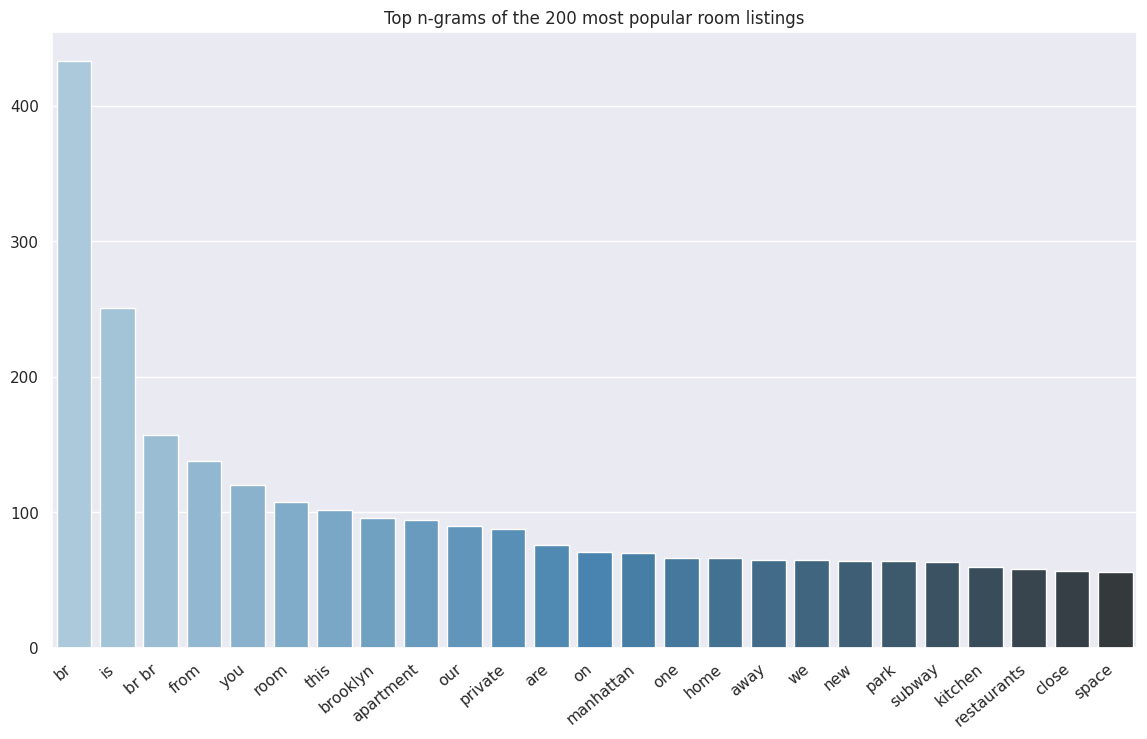

In [111]:
import warnings
warnings.filterwarnings('ignore')

# Assuming 'listing' and 'omit_words' are already defined
top_ngrams = top_words(
    listings.sort_values('reviews_per_month', ascending=False)['description'].iloc[:200],
    ngram_range=(1, 2),
    unwanted_words=omit_words,
    min_occurrences=10
)
top_ngrams = top_ngrams[:25]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=[x[0] for x in top_ngrams], y=[x[1] for x in top_ngrams], ax=ax, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top n-grams of the 200 most popular room listings')
plt.show()


- Popular rooms are the ones with access to amenities readily, as well as location advantages. You can further analyse to confirm this by the price and amenities features corresponding to a listing in the dataset
- The immediate neighbourhood is heavily mentioned in the name, whereas the description constains the features of the listing, which is heavily correlated with the price, as we will see ahead

## **FEATURE ENGINEERING**

Let's get review_span_days & recency_last_review from columns first_review and last_review

In [112]:
# Convert to datetime
listings['first_review'] = pd.to_datetime(listings['first_review'], errors='coerce')
listings['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce')

# Review Span Duration (days)
listings['review_span_days'] = (listings['last_review'] - listings['first_review']).dt.days

# Recency of Last Review (days)
listings['recency_last_review'] = (pd.Timestamp.today() - listings['last_review']).dt.days


We wish to analyse the Amenities feature as it will be a key feature in prediction of prices of a listing

In [113]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer
import re
lemmatizer = WordNetLemmatizer()
amen_corpus = []

for i in range(len(listings)):
    review = re.sub('[^a-zA-Z]', ' ', listings.amenities[i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_2]

    review = ' '.join(review)
    amen_corpus.append(review)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [114]:
amen_corpus[:3]

['dedicated workspace essential cooking basic stove blender dish silverware hot water dining table dryer washer lock bedroom door kitchen bathtub oven refrigerator wine glass single level home fire extinguisher fast wifi u mbps luggage dropoff allowed microwave bed linen cleaning available stay conditioner smoke alarm elevator body soap clothing storage self check hair dryer backyard carbon monoxide alarm freezer heating shower gel coffee maker paid parking premise extra pillow blanket cleaning product long term stay allowed free street parking shampoo laundromat nearby lockbox',
 'dedicated workspace essential cooking basic stove dish silverware tv hot water kitchen keypad bathtub hanger refrigerator oven fire extinguisher luggage dropoff allowed bed linen cleaning available stay baking sheet smoke alarm self check hair dryer wifi iron carbon monoxide alarm ethernet connection heating air conditioning coffee maker paid parking premise extra pillow blanket long term stay allowed free s

Creating a bag of words model using the amenities we are interested in, for feature use in the dataset. We will subsequently make a document-term matrix, and convert the sparse representation into a numpy array, which will be converted to append to our original dataframe.

In [115]:
vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), vocabulary=['dryer', 'washer', 'wifi', 'indoor fireplace', 'Free street parking', 'microwave', 'hot water',
                                                                      'kitchen', 'refrigerator', 'hair dryer', 'iron', 'Patio or balcony',
                                                                      'heating', 'air conditioning',
                                                                       'breakfast', 'Essentials', 'dishwasher', 'stove',
                                                                      'coffee maker',  'oven', 'cable tv', 'Shared fenced garden or backyard', 'Free parking on premises',
                                                                      'private entrance', 'gym', 'pool', 'Beach essentials', 'Extra pillows and blankets', 'Dishes and silverware'
                                                                      ])
para_matrix = vect.fit(amen_corpus)
#vect.get_feature_names()

amenities_matrix = vect.transform(amen_corpus).toarray()
amenities_matrix

array([[2, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0],
       ...,
       [2, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0]])

In [116]:
amenities_matrix = pd.DataFrame(amenities_matrix,
                                columns=vect.get_feature_names_out(),
                                index=listings.index)
amenities_matrix = amenities_matrix.rename(columns=lambda x: x.replace(" ","_").replace('-','_'))
listings_final = pd.merge(listings, amenities_matrix, left_index=True, right_index=True)
listings_final = listings_final.drop(['amenities'], axis=1)
listings_final = listings_final.fillna(0)
listings_final.iloc[:3, -30:]

recency_last_review  dryer  washer  wifi  indoor_fireplace  \
0               2512.0      2       1     1                 0   
1               1171.0      1       0     1                 0   
2                746.0      2       1     1                 0   

   Free_street_parking  microwave  hot_water  kitchen  refrigerator  ...  \
0                    0          1          1        1             1  ...   
1                    0          0          1        1             1  ...   
2                    0          1          1        1             1  ...   

   oven  cable_tv  Shared_fenced_garden_or_backyard  Free_parking_on_premises  \
0     1         0                                 0                         0   
1     1         0                                 0                         0   
2     1         0                                 0                         0   

   private_entrance  gym  pool  Beach_essentials  Extra_pillows_and_blankets  \
0                 0    0     0                 0                           0   
1                 0    0     0                 0                           0   
2                 0    0     0                 0                           0   

   Dishes_and_silverware  
0                      0  
1                      0  
2                      0  

[3 rows x 30 columns]

In [117]:
#Dropping first_review & last_review
listings_final.drop(columns=['first_review', 'last_review'], inplace=True)

In [118]:
listings_final.select_dtypes(include=['float64']).columns

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
       'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_mont

In [119]:
cols_to_int = [
    'indoor_fireplace', 'Free_street_parking',
    'hot_water', 'hair_dryer', 'Patio_or_balcony', 'air_conditioning',
    'coffee_maker', 'cable_tv', 'Shared_fenced_garden_or_backyard',
    'Free_parking_on_premises', 'private_entrance', 'Beach_essentials',
    'Extra_pillows_and_blankets', 'Dishes_and_silverware'
]

listings_final[cols_to_int] = listings_final[cols_to_int].astype('int64')


In [120]:
listings_final.iloc[:3, -30:]

recency_last_review  dryer  washer  wifi  indoor_fireplace  \
0               2512.0      2       1     1                 0   
1               1171.0      1       0     1                 0   
2                746.0      2       1     1                 0   

   Free_street_parking  microwave  hot_water  kitchen  refrigerator  ...  \
0                    0          1          1        1             1  ...   
1                    0          0          1        1             1  ...   
2                    0          1          1        1             1  ...   

   oven  cable_tv  Shared_fenced_garden_or_backyard  Free_parking_on_premises  \
0     1         0                                 0                         0   
1     1         0                                 0                         0   
2     1         0                                 0                         0   

   private_entrance  gym  pool  Beach_essentials  Extra_pillows_and_blankets  \
0                 0    0     0                 0                           0   
1                 0    0     0                 0                           0   
2                 0    0     0                 0                           0   

   Dishes_and_silverware  
0                      0  
1                      0  
2                      0  

[3 rows x 30 columns]

We shall now drop the features that won't prove useful for building a model, and also encode the categorical data for our use-case. Apart from using Amenities, we will drop the rest of the free-text features as we are not interested in a sentiment/topic analysis right now.

In [121]:
pd.set_option('display.max_columns', None)  # Show all columns when printing
print(listings.columns.tolist())  # Print all column names as a list

['id', 'name', 'description', 'neighborhood_overview', 'host_id', 'host_name', 'host_about', 'host_is_superhost', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_ent

We should drop the following columns no questions asked:
'id', 'name', 'description', 'neighborhood_overview', 'host_id', 'host_name', 'host_about', 'calendar_last_scraped'

In [122]:
cols_to_drop = ['id', 'name', 'description', 'neighborhood_overview', 'host_id', 'host_name', 'host_about', 'calendar_last_scraped']
listings_final = listings_final.drop(columns=cols_to_drop, errors='ignore')

Now for all the columns which we log transformed or capped we should have 2 datasets: 1 with all the columns and 1 with all the base columns removed(only the transformed/capped columns)

In [123]:
listings_complete = listings_final
base_columns_to_drop = [
    'minimum_nights',
    'minimum_minimum_nights',
    'minimum_nights_avg_ntm',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews_ly',
    'reviews_per_month',
    'calculated_host_listings_count_shared_rooms',
    'beds',
    'calculated_host_listings_count_entire_homes',
    'bedrooms',
    'accommodates'
]

listings_relevant = listings_final.drop(columns=base_columns_to_drop, errors='ignore')

In [124]:
print(listings_complete.shape)
print(listings_relevant.shape)

(5396, 93)
(5396, 81)


Create a multi collinearity heatmap

In [125]:
def corr_heatmap(df, figsize=(20, 16)):
    sns.set(style="white")

    # Convert Series to DataFrame if needed
    if isinstance(df, pd.Series):
        df = df.to_frame()

    if df.shape[1] < 2:
        raise ValueError("The DataFrame must have at least two columns to compute a correlation matrix.")

    corr = df.corr()

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=figsize)

    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
                cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max(),
                xticklabels=True, yticklabels=True)

    # Rotate x labels vertically and reduce font size for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()


In [126]:
listings_trans = pd.get_dummies(listings_complete)

In [127]:
listings_trans = listings_trans.drop(['Free_street_parking', 'Patio_or_balcony', 'Essentials', 'Shared_fenced_garden_or_backyard', 'Free_parking_on_premises', 'Beach_essentials', 'Extra_pillows_and_blankets',
                    'Dishes_and_silverware'], axis=1)

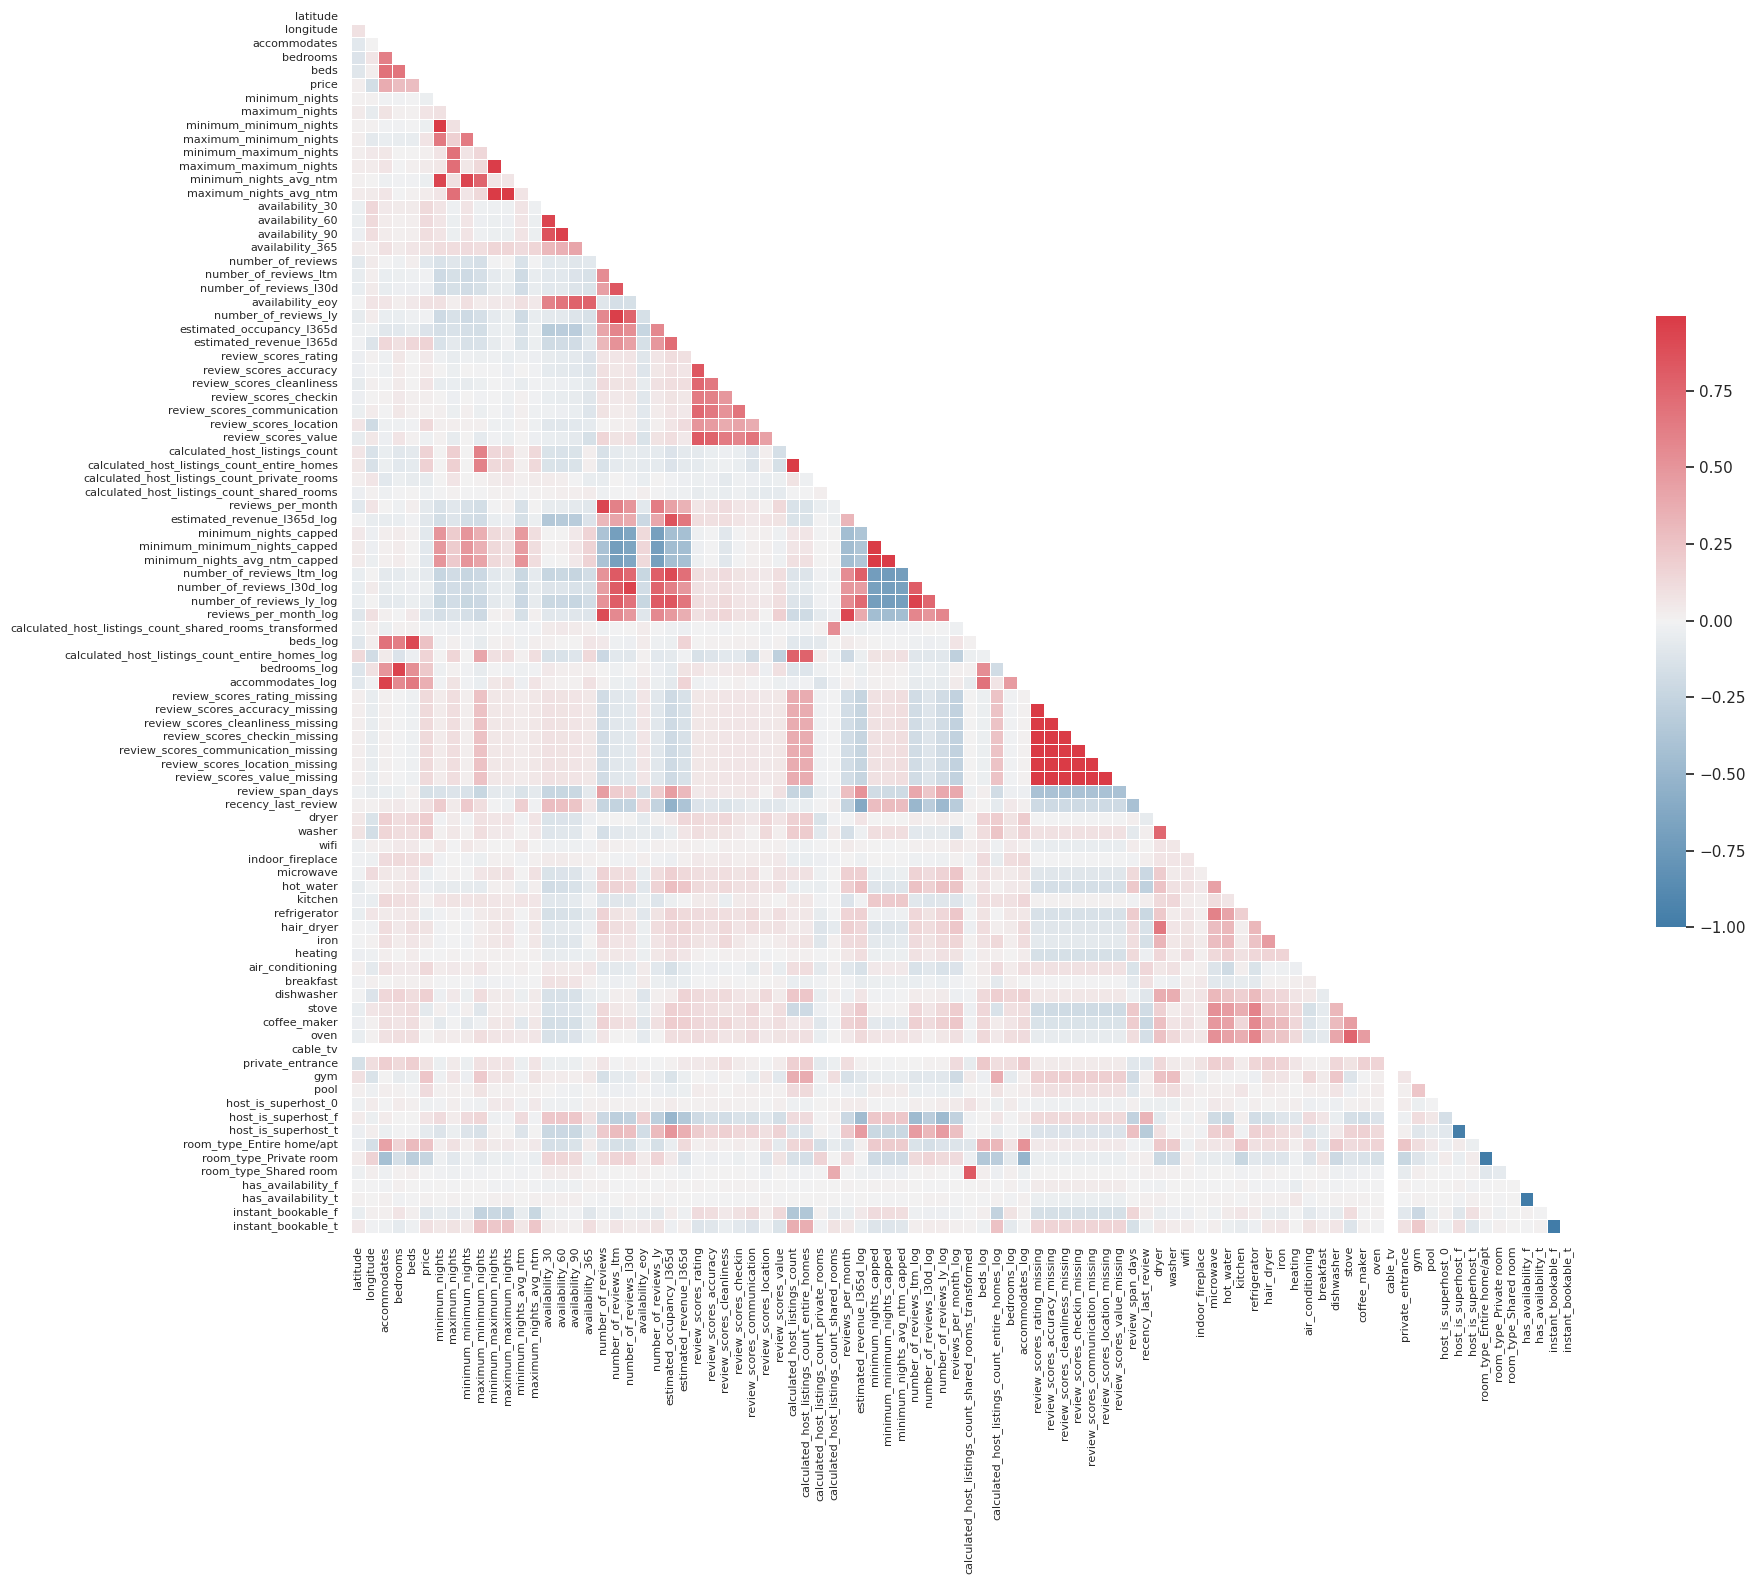

In [128]:
filtered_listing_trans = listings_trans.drop(list(listings_trans.columns[listings_trans.columns.str.startswith('neighbourhood')]), axis=1)

if filtered_listing_trans.shape[1] < 2:
    raise ValueError("The DataFrame must have at least two columns after filtering to compute a correlation matrix.")

corr_heatmap(filtered_listing_trans)

In [129]:
listings_trans1 = pd.get_dummies(listings_relevant)

In [130]:
listings_trans1 = listings_trans1.drop(['Free_street_parking', 'Patio_or_balcony', 'Essentials', 'Shared_fenced_garden_or_backyard', 'Free_parking_on_premises', 'Beach_essentials', 'Extra_pillows_and_blankets',
 'Dishes_and_silverware'], axis=1)

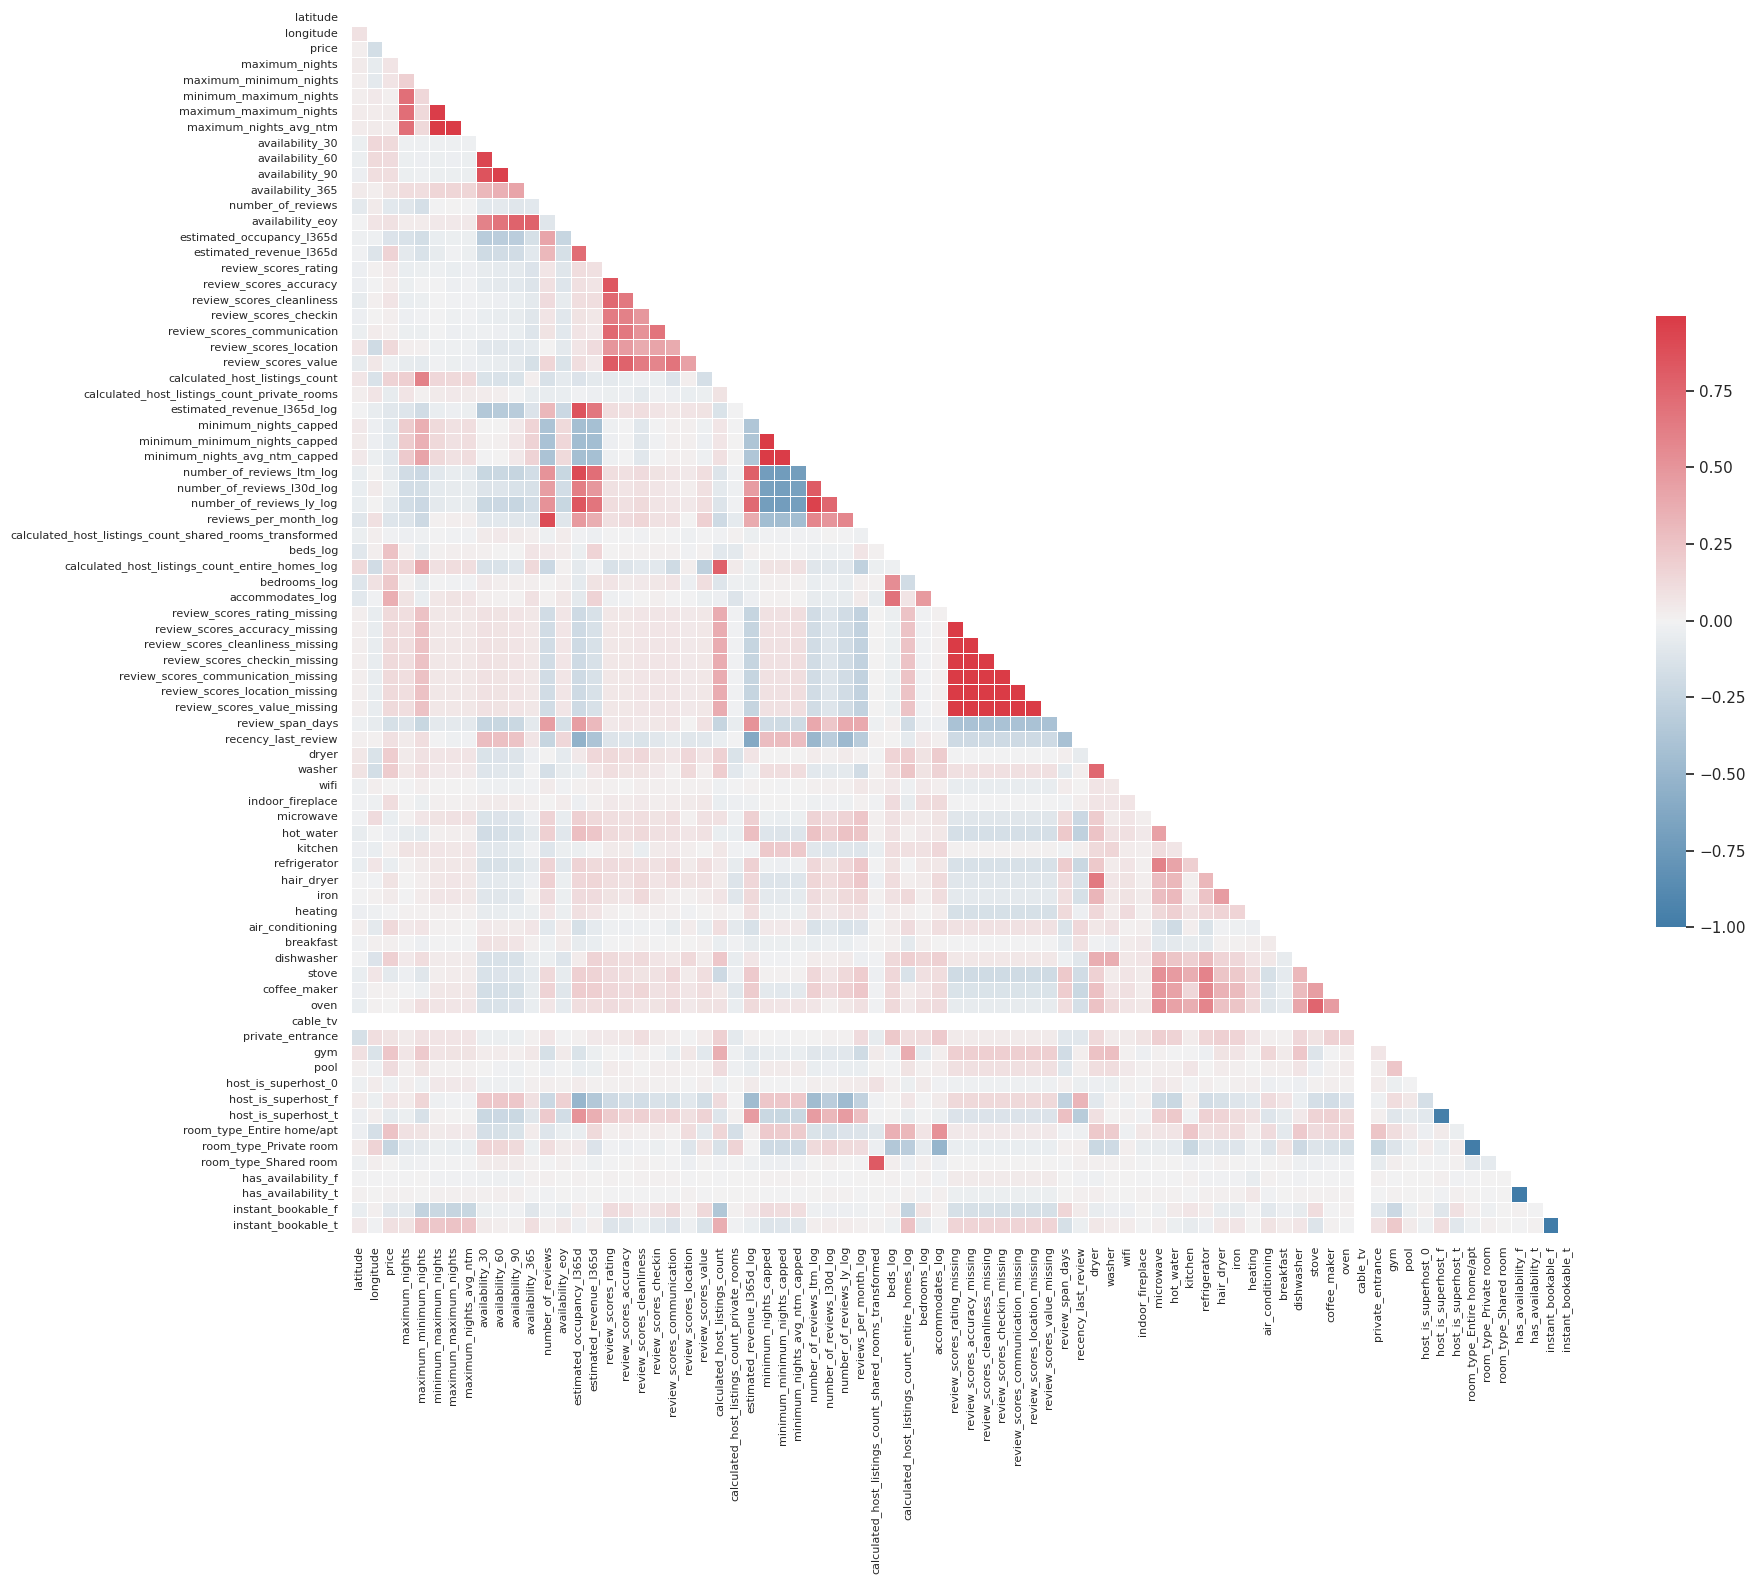

In [131]:
filtered_listing_trans1 = listings_trans1.drop(list(listings_trans1.columns[listings_trans1.columns.str.startswith('neighbourhood')]), axis=1)

if filtered_listing_trans1.shape[1] < 2:
    raise ValueError("The DataFrame must have at least two columns after filtering to compute a correlation matrix.")

corr_heatmap(filtered_listing_trans1)

We can visibly see some of the features to be very correlated. Let's do VIF(Variance Inflation Factor) to verify all this.

In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_multicollinear_pairs(df, target_column='price', vif_threshold=5.0):
    """
    Identify pairs of features where one column should be removed due to high VIF.

    Parameters:
    - df: pandas DataFrame with features and target
    - target_column: name of target column to exclude from VIF calculation
    - vif_threshold: float, VIF value above which feature is flagged

    Returns:
    - List of tuples (feature, VIF) flagged as multicollinear candidates
    """
    # Select numeric features except target
    X = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target_column], errors='ignore')

    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Filter features exceeding threshold
    high_vif = vif[vif['VIF'] > vif_threshold]

    # Sort descending by VIF
    high_vif = high_vif.sort_values(by='VIF', ascending=False)

    pairs_to_consider = []

    for _, row in high_vif.iterrows():
        feature = row['feature']
        vif_value = row['VIF']
        pairs_to_consider.append((feature, vif_value))

    return pairs_to_consider

In [133]:
pairs = vif_multicollinear_pairs(listings_trans1, target_column='price', vif_threshold=5.0)
print("Features suggested for removal due to high multicollinearity (VIF > 5):")
for feature, vif_value in pairs:
    print(f"{feature}: VIF = {vif_value:.2f}")


Features suggested for removal due to high multicollinearity (VIF > 5):
review_scores_value_missing: VIF = inf
review_scores_accuracy_missing: VIF = inf
review_scores_rating_missing: VIF = inf
review_scores_communication_missing: VIF = inf
review_scores_location_missing: VIF = inf
review_scores_checkin_missing: VIF = inf
review_scores_cleanliness_missing: VIF = inf
longitude: VIF = 350430.11
latitude: VIF = 348681.01
review_scores_rating: VIF = 2058.96
review_scores_accuracy: VIF = 1412.21
minimum_nights_capped: VIF = 1381.98
minimum_nights_avg_ntm_capped: VIF = 1381.38
review_scores_checkin: VIF = 1212.97
review_scores_communication: VIF = 1091.68
review_scores_value: VIF = 945.42
minimum_minimum_nights_capped: VIF = 716.43
maximum_nights_avg_ntm: VIF = 619.98
review_scores_cleanliness: VIF = 584.45
review_scores_location: VIF = 568.64
maximum_maximum_nights: VIF = 323.69
minimum_maximum_nights: VIF = 172.92
availability_60: VIF = 87.73
availability_90: VIF = 82.67
number_of_reviews_l

dropped feature with very high collinearity

In [134]:
high_vif_features = [
    'review_scores_accuracy_missing', 'review_scores_rating_missing', 'review_scores_cleanliness_missing',
    'review_scores_checkin_missing', 'review_scores_communication_missing', 'review_scores_location_missing',
    'review_scores_value_missing', 'longitude', 'latitude', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_location',
    'maximum_nights_avg_ntm', 'maximum_maximum_nights', 'minimum_maximum_nights', 'availability_60',
    'availability_90', 'number_of_reviews_ltm', 'availability_eoy', 'wifi', 'dryer', 'accommodates',
    'estimated_occupancy_l365d', 'beds', 'number_of_reviews_ly', 'estimated_revenue_l365d', 'reviews_per_month',
    'bedrooms', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'maximum_nights', 'maximum_minimum_nights'
]

final_listings = listings_relevant.drop(columns=high_vif_features, errors='ignore')

In [135]:
cols_to_check = [
    'minimum_nights_capped', 'minimum_minimum_nights_capped', 'review_scores_value',
    'number_of_reviews_ltm', 'accommodates', 'beds', 'number_of_reviews_ly_log',
    'estimated_revenue_l365d', 'bedrooms', 'availability_365'
]

for col in cols_to_check:
    if col in final_listings.columns:
        final_listings.drop(columns=[col], inplace=True)
        print(f"Dropped column: {col}")
    else:
        print(f"{col} already deleted or does not exist.")


Dropped column: minimum_nights_capped
Dropped column: minimum_minimum_nights_capped
Dropped column: review_scores_value
number_of_reviews_ltm already deleted or does not exist.
accommodates already deleted or does not exist.
beds already deleted or does not exist.
Dropped column: number_of_reviews_ly_log
estimated_revenue_l365d already deleted or does not exist.
bedrooms already deleted or does not exist.
Dropped column: availability_365


In [136]:
listings_trans_final = pd.get_dummies(final_listings)
listings_trans_final = listings_trans_final.drop(['Free_street_parking', 'Patio_or_balcony', 'Essentials', 'Shared_fenced_garden_or_backyard', 'Free_parking_on_premises', 'Beach_essentials', 'Extra_pillows_and_blankets',
 'Dishes_and_silverware'], axis=1)

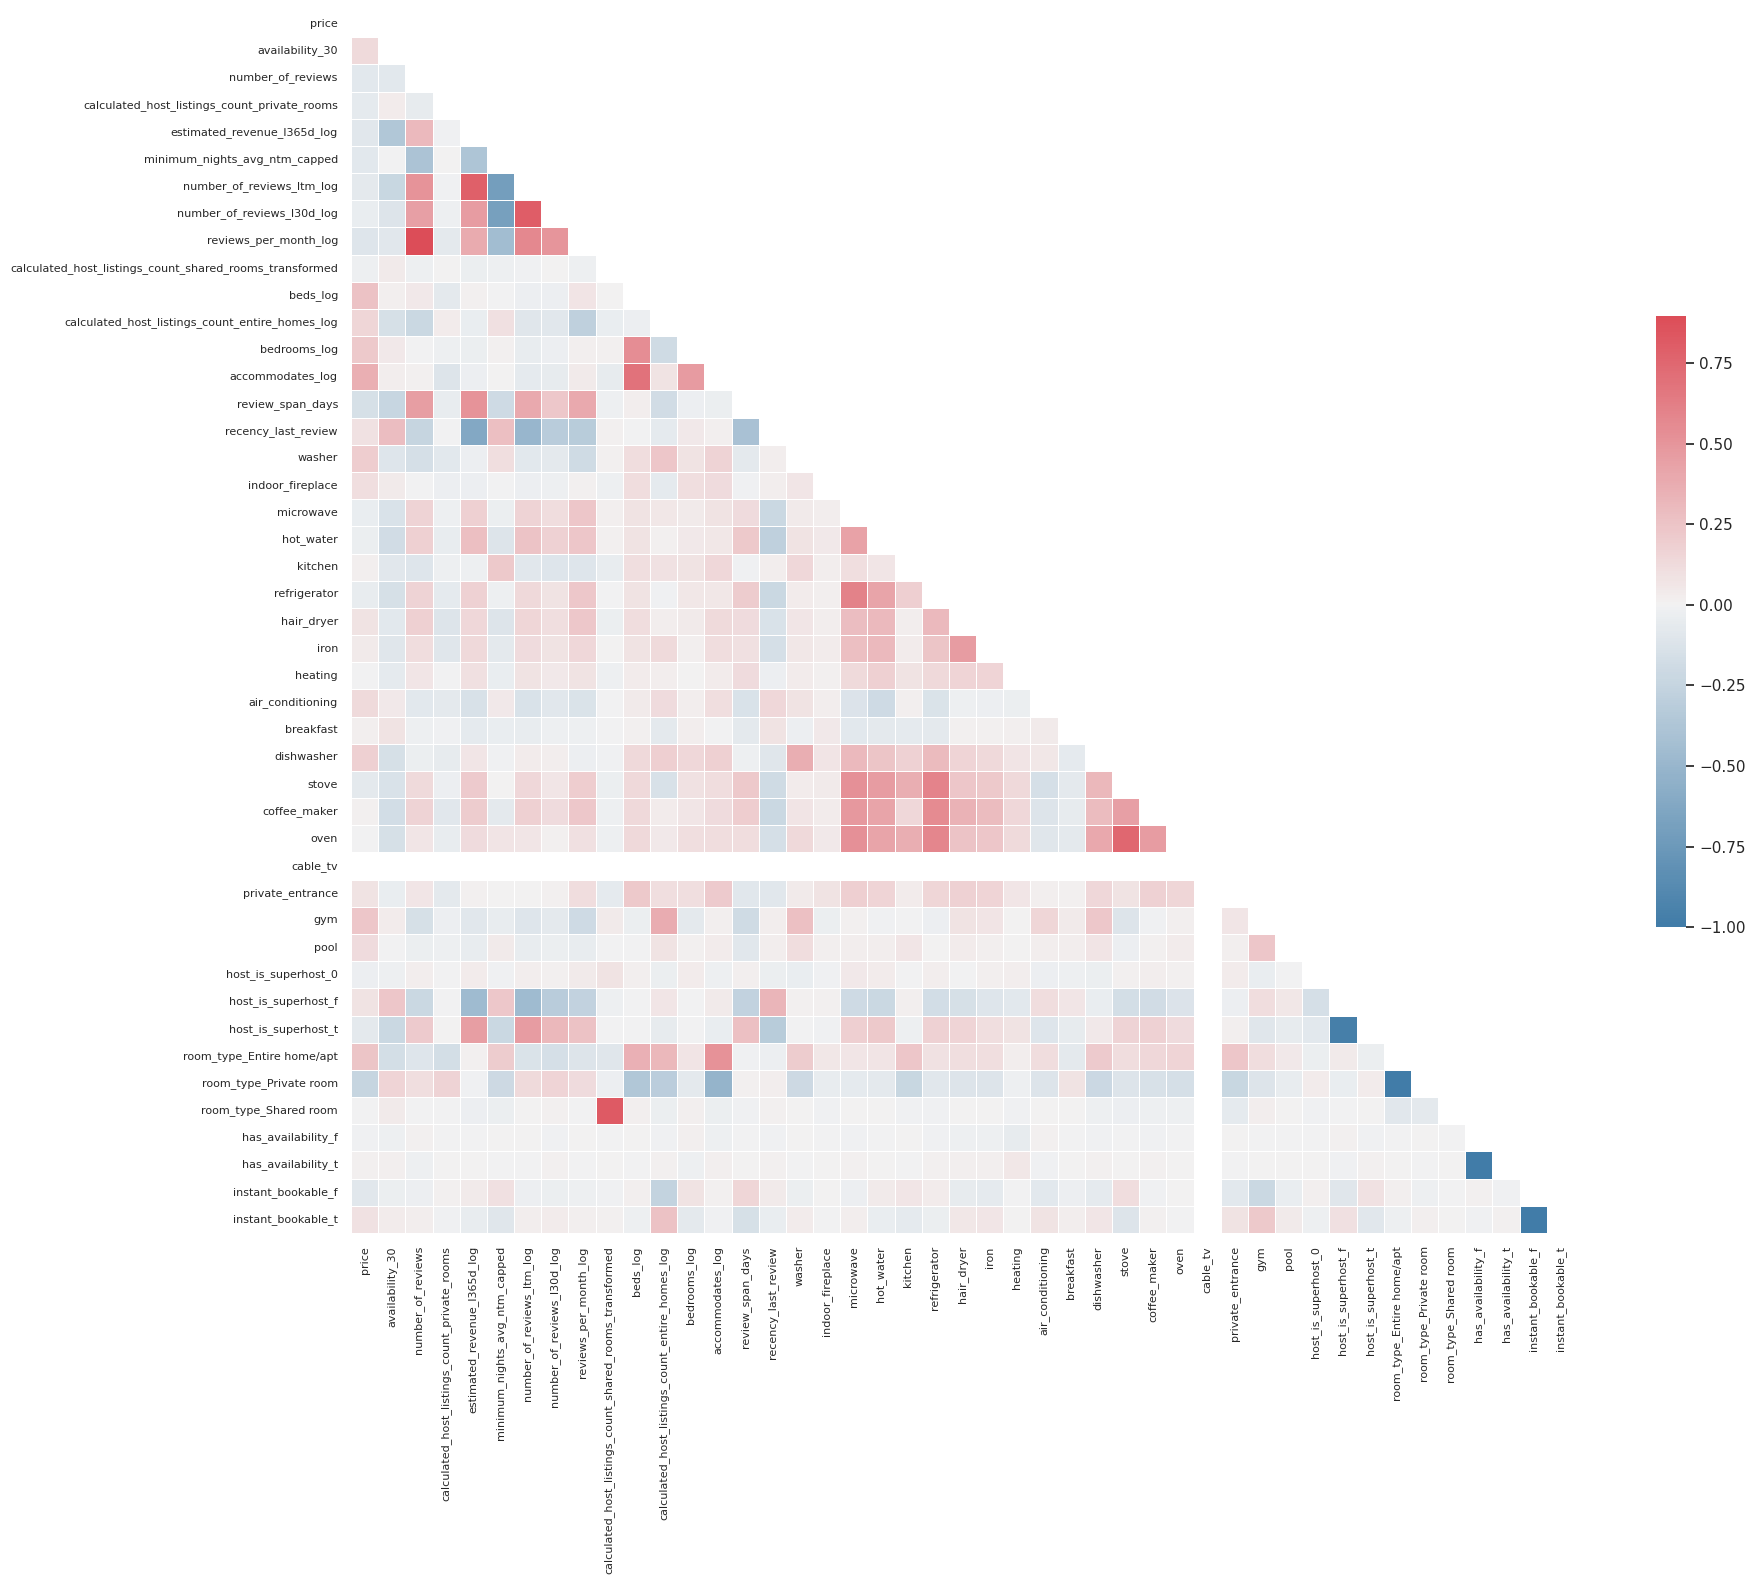

In [137]:
filtered_listing_trans_final = listings_trans_final.drop(list(listings_trans_final.columns[listings_trans_final.columns.str.startswith('neighbourhood')]), axis=1)

if filtered_listing_trans_final.shape[1] < 2:
    raise ValueError("The DataFrame must have at least two columns after filtering to compute a correlation matrix.")

corr_heatmap(filtered_listing_trans_final)

In [138]:
df = listings_trans_final

In [139]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['price', 'availability_30', 'number_of_reviews',
       'calculated_host_listings_count_private_rooms',
       'estimated_revenue_l365d_log', 'minimum_nights_avg_ntm_capped',
       'number_of_reviews_ltm_log', 'number_of_reviews_l30d_log',
       'reviews_per_month_log',
       'calculated_host_listings_count_shared_rooms_transformed', 'beds_log',
       'calculated_host_listings_count_entire_homes_log', 'bedrooms_log',
       'accommodates_log', 'review_span_days', 'recency_last_review', 'washer',
       'indoor_fireplace', 'microwave', 'hot_water', 'kitchen', 'refrigerator',
       'hair_dryer', 'iron', 'heating', 'air_conditioning', 'breakfast',
       'dishwasher', 'stove', 'coffee_maker', 'oven', 'cable_tv',
       'private_entrance', 'gym', 'pool'],
      dtype='object')

In [140]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
  print(col, " skewness = ", df[col].skew())
  print('\n')

price  skewness =  9.3541264161971


availability_30  skewness =  0.38722999555300763


number_of_reviews  skewness =  3.060351935330547


calculated_host_listings_count_private_rooms  skewness =  17.134359595216882


estimated_revenue_l365d_log  skewness =  -0.021494347495540404


minimum_nights_avg_ntm_capped  skewness =  -1.495140071043003


number_of_reviews_ltm_log  skewness =  1.3896984695108605


number_of_reviews_l30d_log  skewness =  2.402880201744252


reviews_per_month_log  skewness =  0.9970499498324998


calculated_host_listings_count_shared_rooms_transformed  skewness =  10.142517063828482


beds_log  skewness =  1.0337525482950456


calculated_host_listings_count_entire_homes_log  skewness =  2.9672119167836466


bedrooms_log  skewness =  -0.038412558216042954


accommodates_log  skewness =  0.8429319090348504


review_span_days  skewness =  0.009009072227341172


recency_last_review  skewness =  1.9215510632519053


washer  skewness =  0.28766298217157327


indoor_firep

based on this we need need to log transform some columns

In [141]:
pos_skewed_col = ['number_of_reviews', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms_transformed',
            'recency_last_review', 'indoor_fireplace', 'breakfast', 'pool', 'price']
for col in pos_skewed_col:

    df[col] = np.log1p(df[col])


In [142]:
from sklearn.preprocessing import PowerTransformer

# List of negatively skewed columns to transform
neg_skewed_col = ['minimum_nights_avg_ntm_capped', 'kitchen', 'heating', 'air_conditioning']

pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the columns, replacing them inplace
df[neg_skewed_col] = pt.fit_transform(df[neg_skewed_col])


In [143]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
  print(col, " skewness = ", df[col].skew())
  print('\n')

price  skewness =  0.599735286448844


availability_30  skewness =  0.38722999555300763


number_of_reviews  skewness =  -0.5136992573292595


calculated_host_listings_count_private_rooms  skewness =  2.143543483793876


estimated_revenue_l365d_log  skewness =  -0.021494347495540404


minimum_nights_avg_ntm_capped  skewness =  0.4798550787850096


number_of_reviews_ltm_log  skewness =  1.3896984695108605


number_of_reviews_l30d_log  skewness =  2.402880201744252


reviews_per_month_log  skewness =  0.9970499498324998


calculated_host_listings_count_shared_rooms_transformed  skewness =  10.142517063828477


beds_log  skewness =  1.0337525482950456


calculated_host_listings_count_entire_homes_log  skewness =  2.9672119167836466


bedrooms_log  skewness =  -0.038412558216042954


accommodates_log  skewness =  0.8429319090348504


review_span_days  skewness =  0.009009072227341172


recency_last_review  skewness =  -1.6307502464407657


washer  skewness =  0.28766298217157327


indoor_f

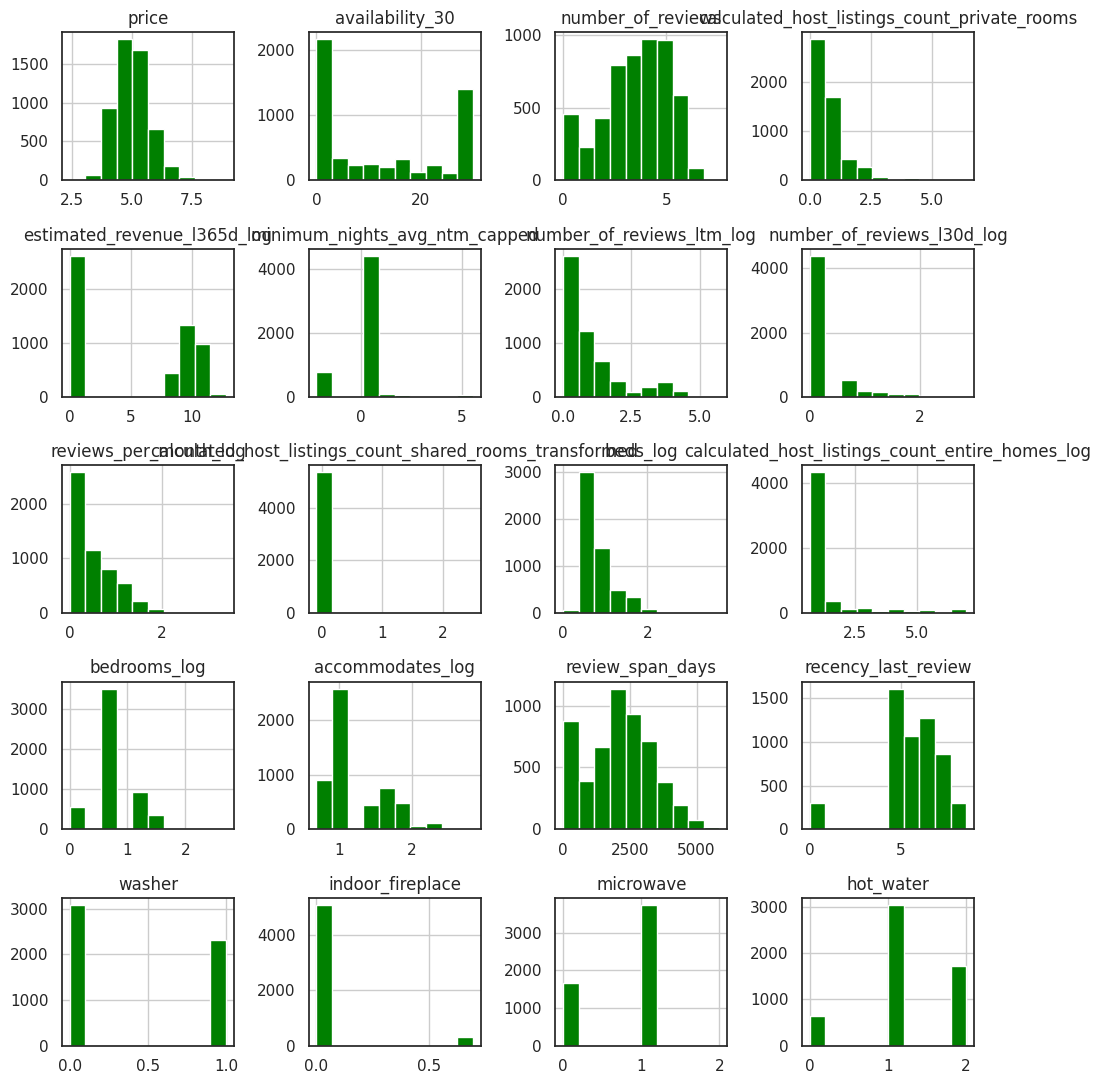

In [144]:
numerical_features = [
    'price',
    'availability_30',
    'number_of_reviews',
    'calculated_host_listings_count_private_rooms',
    'estimated_revenue_l365d_log',
    'minimum_nights_avg_ntm_capped',
    'number_of_reviews_ltm_log',
    'number_of_reviews_l30d_log',
    'reviews_per_month_log',
    'calculated_host_listings_count_shared_rooms_transformed',
    'beds_log',
    'calculated_host_listings_count_entire_homes_log',
    'bedrooms_log',
    'accommodates_log',
    'review_span_days',
    'recency_last_review',
    'washer',
    'indoor_fireplace',
    'microwave',
    'hot_water'
]

df[numerical_features].hist(figsize=(10, 11), color="green")
plt.tight_layout()
plt.show()

Now we can move foward as we are now done with the EDA and have our final dataset.

# **TRAINING DATASET**

In [145]:
from sklearn.preprocessing import StandardScaler
X = df.drop('price', axis=1)
y = df.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# **MODEL BUILDING**

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1) **SIMPLE LINEAR REGRESSION**

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [148]:
reg = LinearRegression()
save_1 = reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error(RMSE): {rmse_train}")
print(f"Testing error(RMSE): {rmse_test}")
print(f"R2: {r2_score(y_test, y_test_pred)}")

Training error(RMSE): 0.38687687820673056
Testing error(RMSE): 0.4210634988388166
R2: 0.6589066054826498


## 2) **Support Vector Machine** regressor

In [149]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [150]:
svr = LinearSVR(max_iter=50000)

save_2 = svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
print('Mean Absolute Error on Training Set:', mean_absolute_error(y_train, y_train_pred))

svr_scores = (-cross_val_score(svr, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
svr_scores.mean()

Mean Absolute Error on Training Set: 0.27537323472885683


np.float64(0.34888987296941104)

## 3) Let us now look into training a Tree boosting model. We will employ a **vanilla XGBoost** model, and subsequently cross validate and tune the hyperparameters to improve the performance

In [151]:
from xgboost import XGBRegressor
import xgboost as xgb

In [152]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.0293
Validation MSE: 0.1243

Training r2: 0.9438
Validation r2: 0.7608


In [153]:
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_reg, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = np.argsort(result.importances_mean)[::-1][:47]  # Select top 47 features

imp_features = X_train.columns[sorted_idx].tolist()


In [154]:
X_imp = df[imp_features]
y = df['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.33, random_state=42)


In [155]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 100, 500],
    'max_depth': [5, 20, 40, 60],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_reg_tune = xgb.XGBRegressor()

grid_search = GridSearchCV(xgb_reg_tune, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}


In [156]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nTraining RMSE: {rmse_train}")
print(f"Testing RMSE: {rmse_test}")



Training RMSE: 0.13267652013758285
Testing RMSE: 0.34576693625891103


In [157]:
listings.shape

(5396, 75)

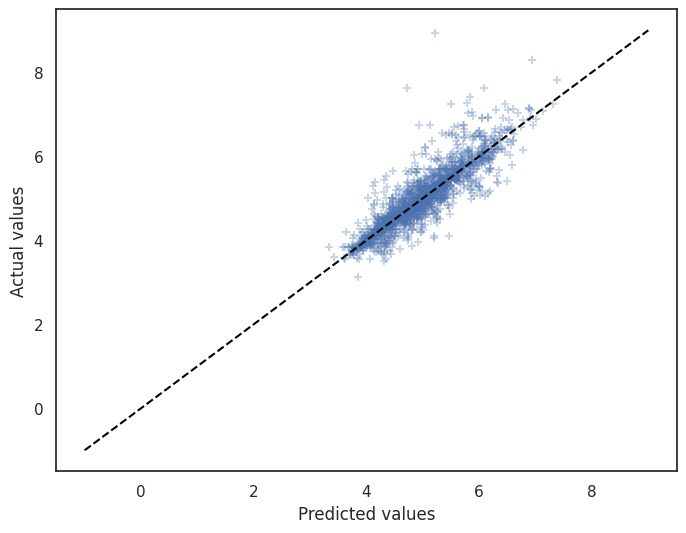

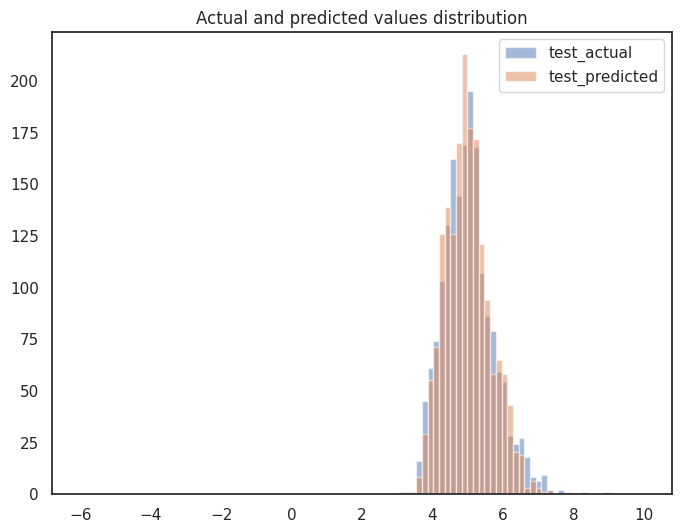

In [158]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(y_test_pred, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.plot(list(range(-1,10)), list(range(-1,10)), color='black', linestyle='--')


plt.figure(figsize=(8, 6))
bins = np.linspace(-6,10, 100)
plt.hist(y_test, bins, label='test_actual', alpha=0.5)
plt.hist(y_test_pred, bins, label='test_predicted', alpha=0.5)
plt.title('Actual and predicted values distribution')
plt.legend(loc='upper right')
plt.show()

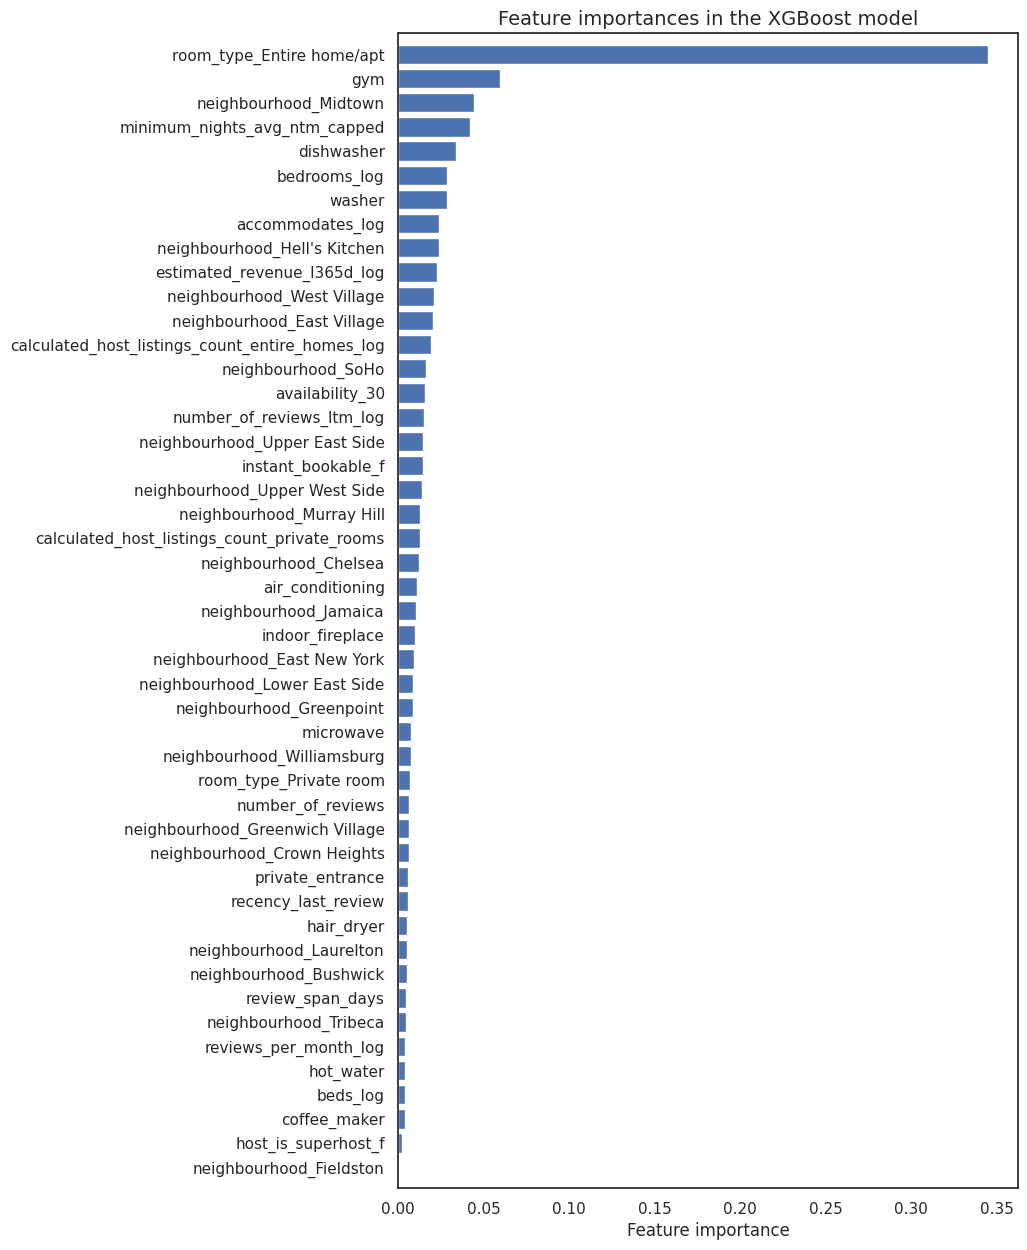

In [159]:
best_model.fit(X_train, y_train)
weights_xgb = pd.DataFrame(best_model.feature_importances_, columns=['weight'], index=X_train.columns)
weights_xgb.sort_values('weight', inplace=True)

#plotting feature weightages
plt.figure(figsize=(8,15))
plt.barh(weights_xgb.index, weights_xgb.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [160]:
import joblib

joblib.dump(best_model, 'xgb_price_model.pkl')

['xgb_price_model.pkl']

In [161]:
from google.colab import files
files.download('xgb_price_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [162]:
# X_imp = df[imp_features]
# y = df['price']

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.33, random_state=42)


In [163]:
# xgb_reg_tune = xgb.XGBRegressor()

# parameters = {'n_estimators': [10, 100, 500],
#               'max_depth': [5, 20, 40, 60],
#               'min_samples_leaf': [5, 10, 50],
#               'max_features': ['sqrt', 'auto', 0.5, 1],
#              }

# grid_obj = GridSearchCV(xgb_reg_tune, parameters, scoring='neg_mean_squared_error', n_jobs=1, cv=3)
# grid_fit = grid_obj.fit(X_train, y_train)

# best_reg = grid_fit.best_estimator_

# y_train_pred = best_reg.predict(X_train)
# y_test_pred = best_reg.predict(X_test)
# rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
# rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
# print(best_reg)
# print(f"\nTraining error: {rmse_train}")
# print(f"Testing error: {rmse_test}")

## 4) We shall now observe the performance of a **Neural Network with L1 regularization** for the given task. We will use ReLU activation function, a linear function for the output layer and a mean sqaured loss as this is a regression task.


In [164]:
!pip install tensorflow

In [165]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

In [166]:
X, y = df[imp_features],\
                     df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [167]:
#FUNCTION TO EVALUATING THE MODEL
def model_eval_nn(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='red')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()

    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)

    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')

    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')

    plt.show()

In [168]:
net = models.Sequential()
net.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(1, activation='linear'))

#compiling
net.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

print(net.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,057 (926.00 KB)

 Trainable params: 237,057 (926.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [169]:
net_start = time.time()
net_history = net.fit(X_train, y_train, epochs=150,batch_size=256,validation_split = 0.1)
net_end = time.time()

print(f"Time taken to run: {round((net_end - net_start)/60,1)} minutes")

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - loss: 7036.4102 - mean_squared_error: 6978.6978 - val_loss: 710.2892 - val_mean_squared_error: 658.4539
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 374.8027 - mean_squared_error: 324.6864 - val_loss: 86.7160 - val_mean_squared_error: 41.6306
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 71.1047 - mean_squared_error: 27.5062 - val_loss: 43.5522 - val_mean_squared_error: 4.2383
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 43.0037 - mean_squared_error: 4.9140 - val_loss: 38.1496 - val_mean_squared_error: 3.5340
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 36.8370 - mean_squared_error: 3.1921 - val_loss: 33.3586 - val_mean_squared_error: 2.4130
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 34.4380 - mean_squared_error: 4.2093 - val_loss: 31.2845 - val_mean_squared_error: 2.9650
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.8656 - mean_squared_er

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training MSE: 0.3712
Test MSE: 0.3768

Training r2: 0.288
Test r2: 0.275


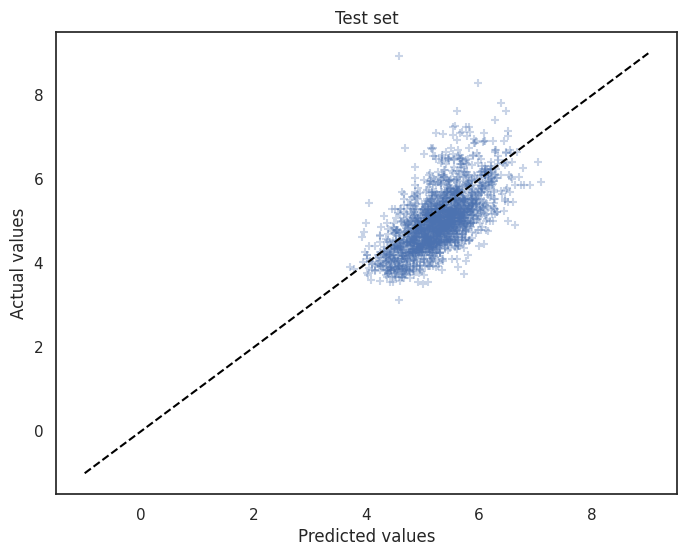

In [170]:
y_test_pred = net.predict(X_test)
y_train_pred = net.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Test r2:", round(r2_score(y_test, y_test_pred),4))


fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(y_test_pred, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Test set')
ax.plot(list(range(-1,10)), list(range(-1,10)), color='black', linestyle='--')

# **CONCLUSION**
- **XGBoost emerged as the best-performing model** with **82.4% R²** on validation set, demonstrating superior predictive accuracy for price estimation.

- Linear Regression provided a strong baseline with 71.5% R², showing that fundamental linear relationships exist in the data.

- Neural Network achieved moderate results with ~51% R², indicating that deep learning may be less suitable for this tabular dataset.

- Feature engineering and data preprocessing were critical, transforming initial poor performance (R² ~0.06) to highly effective models.

- **Model generalization was excellent across all approaches**, with minimal overfitting observed in training vs. testing performance.

- **Room type** and **accommodation capacity** are **primary price drivers**, followed by minimum nights and neighborhood location based on feature importance analysis.

- XGBoost predictions showed tight clustering around actual values, with excellent distribution alignment between predicted and actual prices.

- All models demonstrated robust performance on the 21,000+ sample dataset, indicating **scalability for real-world applications**.

# **Future Goals**

- Deploy the XGBoost model in a production environment for real-time price prediction and recommendation systems

- Develop an ensemble model combining XGBoost, Linear Regression, and Neural Network predictions for potentially enhanced accuracy

- Implement automated model retraining pipelines to adapt to changing market conditions and seasonal pricing patterns

- Expand feature engineering by incorporating external data sources like local events, weather patterns, and economic indicators

- Create interactive dashboards for business stakeholders to explore feature importance and pricing insights

- Conduct A/B testing to measure the business impact of model-driven pricing recommendations

- Explore advanced techniques such as time series forecasting for dynamic pricing and demand prediction

Investigate model interpretability tools like SHAP values for better understanding of individual prediction explanations

Scale the approach to other markets or property types to validate model generalizability

Implement model monitoring and drift detection to ensure sustained performance over time






